# SSAM analysis of mouse VISp, imaged by multiplexed smFISH
- Author: Jeongbin Park
- Date: 2019-10-12

Set plot parametes / define helper functions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar

from sklearn import preprocessing
import pickle

In [2]:
# post-filtering parameter for cell-type map
filter_method = "local"
filter_params = {
    "block_size": 151,
    "method": "mean",
    "mode": "constant",
    "offset": 0.2
}

In [3]:
# Helper function to load precomputed tSNE
def load_tsne(tsne_id):
    with open("zenodo/multiplexed_smFISH/tsne/%s.pkl"%tsne_id, "rb") as f:
        ds.tsne = pickle.load(f)

In [4]:
# Helper function to load precomputed tSNE
def save_tsne(tsne_id):
    with open("zenodo/multiplexed_smFISH/tsne/%s.pkl"%tsne_id, "wb") as f:
        pickle.dump(ds.tsne, f)

## Load data

Load mRNA spot locations

In [5]:
import numpy as np
from collections import defaultdict

pos_dic = defaultdict(lambda: [])

um_per_pixel = 0.1
xmin, ymin, zmin = 10000000, 10000000, 10000000
xmax, ymax, zmax = -10000000, -10000000, -10000000
with open("zenodo/multiplexed_smFISH/raw_data/smFISH_MCT_CZI_Panel_0_spot_table.csv") as f:
    f.readline()
    for line in f:
        e = line.strip().split(',')
        x, y, z, g = e[1], e[2], e[3], e[-1]
        x, y, z = [float(e) for e in [x, y, z]]
        if x > xmax:
            xmax = x
        if y > ymax:
            ymax = y
        if z > zmax:
            zmax = z
        if x < xmin:
            xmin = x
        if y < ymin:
            ymin = y
        if z < zmin:
            zmin = z
        
with open("zenodo/multiplexed_smFISH/raw_data/smFISH_MCT_CZI_Panel_0_spot_table.csv") as f:
    f.readline()
    for line in f:
        e = line.strip().split(',')
        x, y, z, g = e[1], e[2], e[3], e[-1]
        x, y, z = [float(e) for e in [x, y, z]]
        x -= xmin
        y -= ymin
        z -= zmin
        x, y = [e*um_per_pixel + 10 for e in [x, y]]
        z = z * um_per_pixel
        pos_dic[g].append([x, y])
        
for g in pos_dic:
    pos_dic[g] = np.array(pos_dic[g])

## SSAM analysis
### Run KDE and select representative vectors

Initilize SSAM and run KDE

In [6]:
import ssam

/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
width = (xmax - xmin) * um_per_pixel + 10
height = (ymax - ymin) * um_per_pixel + 10
ncores = 10 # Number of cores used for kernel density estimation

In [8]:
all_genes = list(pos_dic.keys())
ds = ssam.SSAMDataset(all_genes, [pos_dic[gene] for gene in all_genes], width, height)
analysis = ssam.SSAMAnalysis(ds, ncores=10, save_dir="zenodo/multiplexed_smFISH/kde", verbose=True)

In [9]:
analysis.run_kde(bandwidth=2.5, use_mmap=False)

Select VISp area

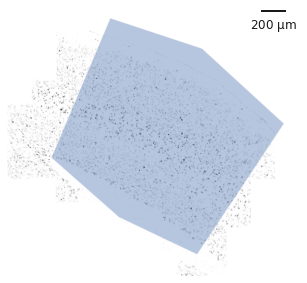

In [10]:
plt.figure(figsize=[5, 5])
ds.plot_l1norm(rotate=1, cmap="Greys")
xy = np.array([[1535,  90],
               [ 795,  335],
               [ 135,  940],
               [ 835, 1995],
               [1465, 1695],
               [2010, 1215]]) # VISp area manually curated

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

patch = Polygon(xy, True)
p = PatchCollection([patch], alpha=0.4)
plt.gca().add_collection(p)

scalebar = ScaleBar(1, 'um') # 1 pixel = 1um
plt.gca().add_artist(scalebar)
plt.tight_layout()

plt.axis('off')
pass

Make input/output mask for VISp region

In [11]:
from matplotlib.path import Path

x, y = np.meshgrid(np.arange(ds.vf.shape[0]), np.arange(ds.vf.shape[1]))
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T

path = Path(xy)
input_mask = path.contains_points(points)
output_mask = input_mask = input_mask.reshape((ds.vf.shape[1], ds.vf.shape[0], 1)).swapaxes(0, 1)

Select local maxima of gene expression in the vector field

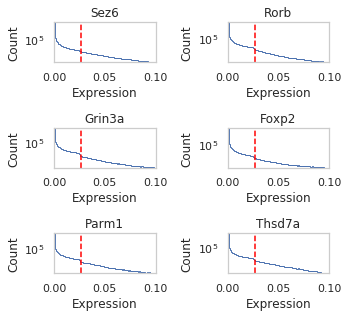

In [12]:
exp_thres = 0.027
viewport = 0.1
gindices = np.arange(len(ds.genes))
np.random.shuffle(gindices)
plt.figure(figsize=[5, 7])
for i, gidx in enumerate(gindices[:6], start=1):
    ax = plt.subplot(5, 2, i)
    n, bins, patches = ax.hist(ds.vf[..., gidx][np.logical_and(ds.vf[..., gidx] > 0, ds.vf[..., gidx] < viewport)], bins=100, log=True, histtype=u'step')
    ax.set_xlim([0, viewport])
    ax.set_ylim([n[-1], n[0]])
    ax.axvline(exp_thres, c='red', ls='--')
    ax.set_title(ds.genes[gidx])
    ax.set_xlabel("Expression")
    ax.set_ylabel("Count")
plt.tight_layout()
pass

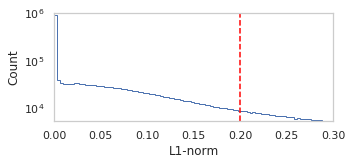

In [13]:
norm_thres = 0.2
gidx = 0
plt.figure(figsize=[5, 2])
#plt.hist(ds.vf[..., gidx][ds.vf[..., gidx] > 0], bins=100, log=True)
n, _, _ = plt.hist(ds.vf_norm[np.logical_and(ds.vf_norm > 0, ds.vf_norm < 0.3)], bins=100, log=True, histtype='step')
ax = plt.gca()
ax.axvline(norm_thres, c='red', ls='--')
ax.set_xlabel("L1-norm")
ax.set_ylabel("Count")

plt.xlim([0, 0.3])
plt.ylim([np.min(n), np.max(n) + 100000])
pass

In [14]:
analysis.find_localmax(search_size=3, min_norm=norm_thres, min_expression=exp_thres, mask=input_mask)

Found 4586 local max vectors.


In [15]:
import pickle
with open("local_max_vectors.pkl", "wb") as f:
    pickle.dump(ds.vf[ds.local_maxs], f)

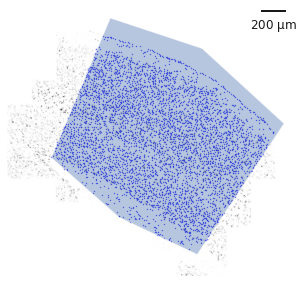

In [16]:
plt.figure(figsize=[5, 5])
ds.plot_l1norm(cmap="Greys", rotate=1)
ds.plot_localmax(c="Blue", rotate=1, s=0.1)

patch = Polygon(xy, facecolor="black", edgecolor="red", linewidth=10, ls="-")
p = PatchCollection([patch], alpha=0.4)
plt.gca().add_collection(p)

scalebar = ScaleBar(1, 'um') # 1 pixel = 1um
plt.gca().add_artist(scalebar)
#plt.show()
plt.tight_layout()

plt.axis('off')

plt.show()

Normalize local maxima vectors and vector field

Writing temporary files...
Running scTransform via Rscript...
Reading output files...


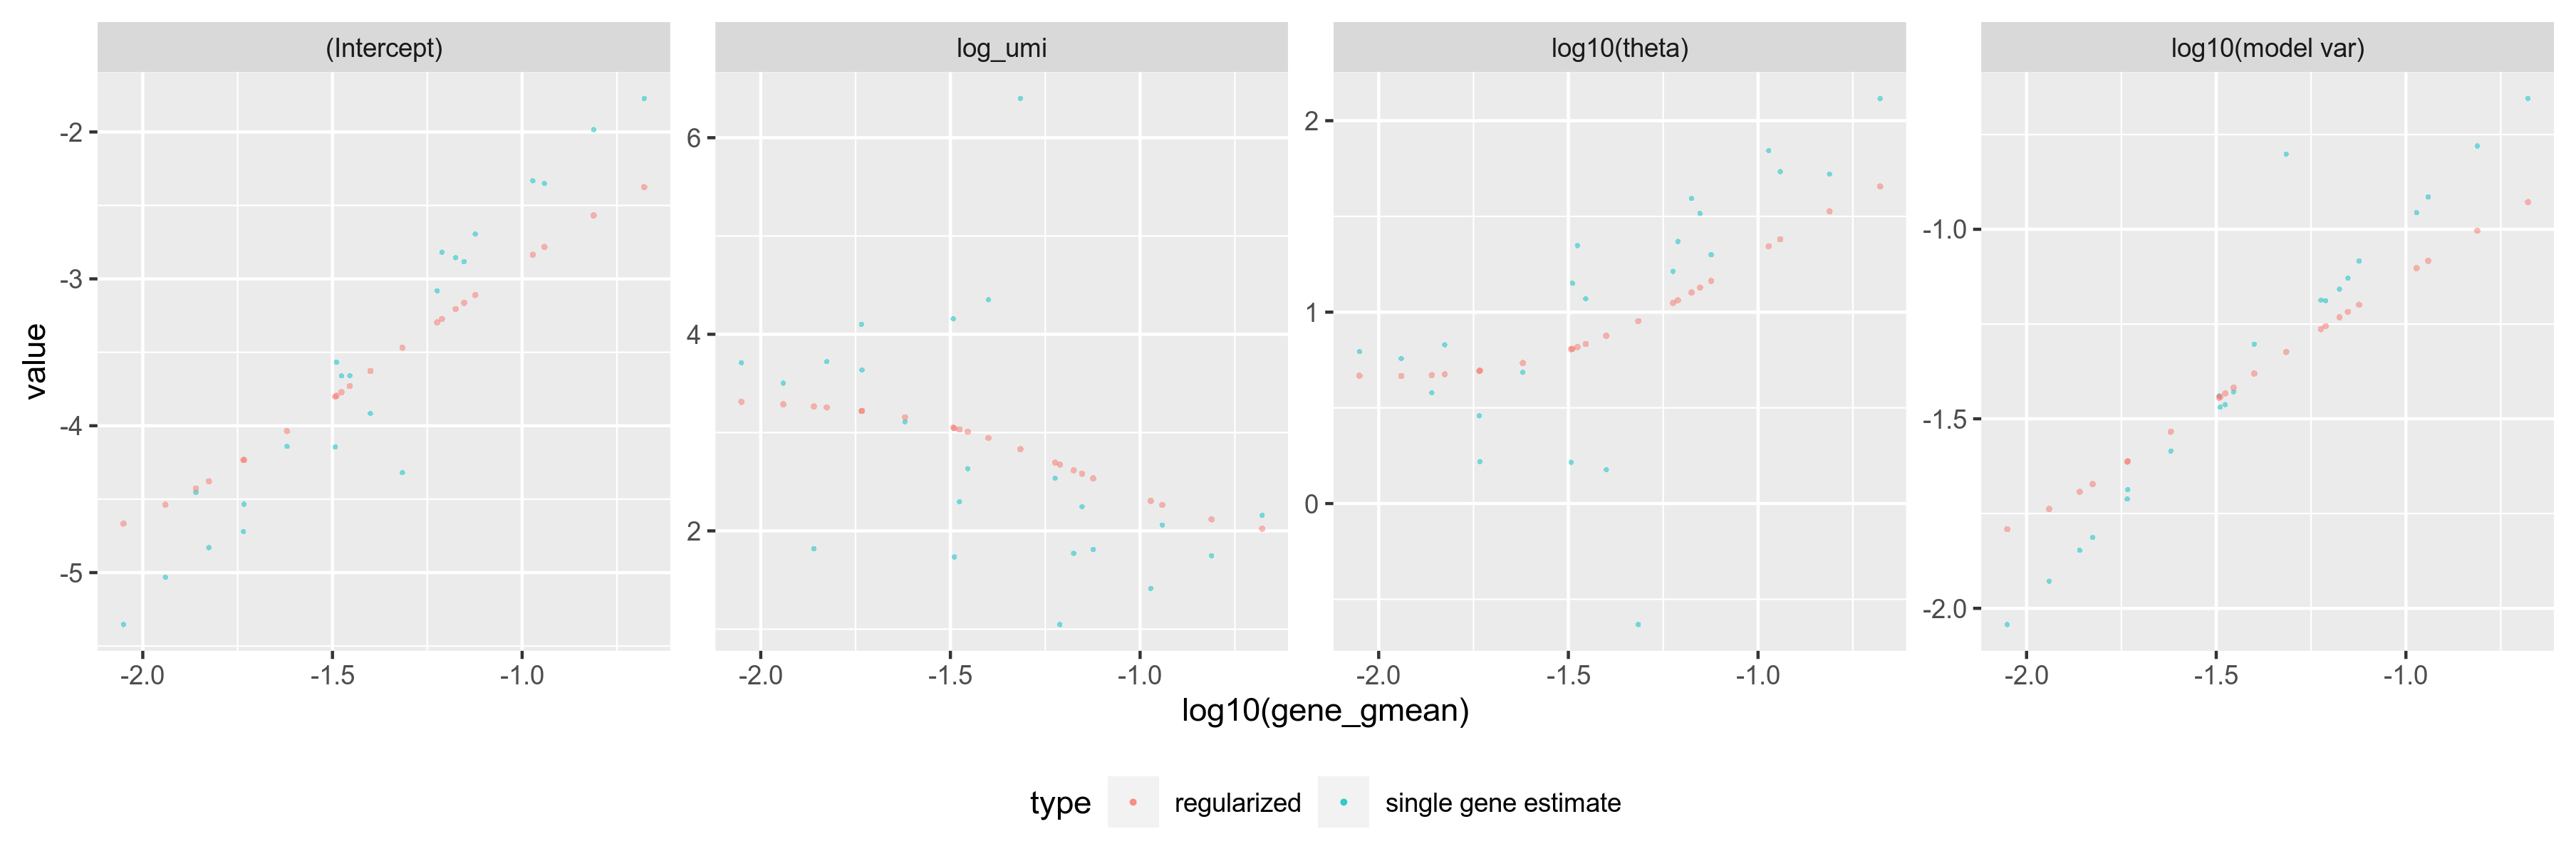

Clipping residuals...


In [17]:
analysis.normalize_vectors_sctransform(vst_kwargs={'plot_model_pars': True})

## SSAM guided mode: using scRNA-seq data (Tasic *et al*. 2018)

Load scRNA-seq data

In [17]:
import pandas as pd
scrna_cl = pd.read_feather("zenodo/multiplexed_smFISH/raw_data/scrna_data_tasic_2018/cl.feather")
scrna_cl_df = pd.read_feather("zenodo/multiplexed_smFISH/raw_data/scrna_data_tasic_2018/cl_df.feather")
scrna_genes = pd.read_feather("zenodo/multiplexed_smFISH/raw_data/scrna_data_tasic_2018/genes.feather")
scrna_counts = pd.read_feather("zenodo/multiplexed_smFISH/raw_data/scrna_data_tasic_2018/counts.feather")

In [18]:
dendrogram_order = [
    'L2/3 IT VISp Rrad',
    'L2/3 IT VISp Adamts2',
    'L2/3 IT VISp Agmat',
    'L4 IT VISp Rspo1',
    'L5 IT VISp Hsd11b1 Endou',
    'L5 IT VISp Whrn Tox2',
    'L5 IT VISp Batf3',
    'L5 IT VISp Col6a1 Fezf2',
    'L5 IT VISp Col27a1',
    'L6 IT VISp Penk Col27a1',
    'L6 IT VISp Penk Fst',
    'L6 IT VISp Col23a1 Adamts2',
    'L6 IT VISp Col18a1',
    'L6 IT VISp Car3',
    'L5 PT VISp Chrna6',
    'L5 PT VISp Lgr5',
    'L5 PT VISp C1ql2 Ptgfr',
    'L5 PT VISp C1ql2 Cdh13',
    'L5 PT VISp Krt80',
    'L5 NP VISp Trhr Cpne7',
    'L5 NP VISp Trhr Met',
    'L6 CT Nxph2 Sla',
    'L6 CT VISp Krt80 Sla',
    'L6 CT VISp Nxph2 Wls',
    'L6 CT VISp Ctxn3 Brinp3',
    'L6 CT VISp Ctxn3 Sla',
    'L6 CT VISp Gpr139',
    'L6b Col8a1 Rprm',
    'L6b VISp Mup5',
    'L6b VISp Col8a1 Rxfp1',
    'L6b P2ry12',
    'L6b VISp Crh',
    'L6b Hsd17b2',
    'Lamp5 Krt73',
    'Lamp5 Fam19a1 Pax6',
    'Lamp5 Fam19a1 Tmem182',
    'Lamp5 Ntn1 Npy2r',
    'Lamp5 Plch2 Dock5',
    'Lamp5 Lsp1',
    'Lamp5 Lhx6',
    'Sncg Slc17a8',
    'Sncg Vip Nptx2',
    'Sncg Gpr50',
    'Sncg Vip Itih5',
    'Serpinf1 Clrn1',
    'Serpinf1 Aqp5 Vip',
    'Vip Igfbp6 Car10',
    'Vip Igfbp6 Pltp',
    'Vip Lmo1 Fam159b',
    'Vip Lmo1 Myl1',
    'Vip Igfbp4 Mab21l1',
    'Vip Arhgap36 Hmcn1',
    'Vip Gpc3 Slc18a3',
    'Vip Ptprt Pkp2',
    'Vip Rspo4 Rxfp1 Chat',
    'Vip Lect1 Oxtr',
    'Vip Rspo1 Itga4',
    'Vip Chat Htr1f',
    'Vip Pygm C1ql1',
    'Vip Crispld2 Htr2c',
    'Vip Crispld2 Kcne4',
    'Vip Col15a1 Pde1a',
    'Sst Chodl',
    'Sst Mme Fam114a1',
    'Sst Tac1 Htr1d',
    'Sst Tac1 Tacr3',
    'Sst Calb2 Necab1',
    'Sst Calb2 Pdlim5',
    'Sst Nr2f2 Necab1',
    'Sst Myh8 Etv1',
    'Sst Chrna2 Glra3',
    'Sst Myh8 Fibin',
    'Sst Chrna2 Ptgdr',
    'Sst Tac2 Myh4',
    'Sst Hpse Sema3c',
    'Sst Hpse Cbln4',
    'Sst Crhr2 Efemp1',
    'Sst Crh 4930553C11Rik',
    'Sst Esm1',
    'Sst Tac2 Tacstd2',
    'Sst Rxfp1 Eya1',
    'Sst Rxfp1 Prdm8',
    'Sst Nts',
    'Pvalb Gabrg1',
    'Pvalb Th Sst',
    'Pvalb Calb1 Sst',
    'Pvalb Akr1c18 Ntf3',
    'Pvalb Sema3e Kank4',
    'Pvalb Gpr149 Islr',
    'Pvalb Reln Itm2a',
    'Pvalb Reln Tac1',
    'Pvalb Tpbg',
    'Pvalb Vipr2',
    'Meis2 Adamts19',
    'CR Lhx5',
    'Astro Aqp4',
    'OPC Pdgfra Grm5',
    'OPC Pdgfra Ccnb1',
    'Oligo Rassf10',
    'Oligo Serpinb1a',
    'Oligo Synpr',
    'VLMC Osr1 Cd74',
    'VLMC Spp1 Hs3st6',
    'VLMC Osr1 Mc5r',
    'VLMC Spp1 Col15a1',
    'Peri Kcnj8',
    'SMC Acta2',
    'Endo Ctla2a',
    'Endo Cytl1',
    'PVM Mrc1',
    'Microglia Siglech'
]

In [228]:
cell_class_colors = {
    "Astro": "#665C47",
    "CR": "#00FF66",
    "Endo": "#8D6C62",
    "L2/3 IT": "#94D9A1",
    "L4 IT": "#00979D",
    "Lamp5": "#DA808C",
    "L5 IT": "#008A61",
    "L5 NP": "#3E9E64",
    "L5 PT": "#0D5B78",
    "L6 CT": "#69A8E6",
    "L6 IT": "#A19922",
    "L6b": "#266180",
    "Macrophage": "#537358",
    "Meis2": "#FF0000",
    "Oligo": "#53776C",
    "Peri": "#665547",
    "Pvalb": "#D93137",
    "Serpinf1": "#8510C0",
    "SMC": "#807059",
    "Sncg": "#8510C0",
    "Sst": "#F15A29",
    "VLMC": "#697255",
    "Vip": "#70559A",
}

In [19]:
scrna_clusters = scrna_cl['cluster_id']

In [20]:
scrna_cl_dic = dict(zip(scrna_cl['cell_id'], scrna_cl['cluster_id']))
scrna_cl_metadata_dic = dict(zip(
    scrna_cl_df['cluster_id'],
    zip(scrna_cl_df['cluster_label'], 
        scrna_cl_df['cluster_color'], )
))

In [21]:
qc_gene_indices = np.sum(scrna_counts > 0, axis=1) > 5
scrna_genes_qc = np.array(scrna_genes)[qc_gene_indices]

In [22]:
scrna_counts_qc = np.array(scrna_counts).T[:, qc_gene_indices]

In [23]:
# Normalize it with sctransform
scrna_data_normalized = np.array(ssam.run_sctransform(scrna_counts_qc)[0])

In [24]:
selected_genes_idx = [list(scrna_genes_qc).index(g) for g in ds.genes]
scrna_uniq_clusters = np.unique(scrna_clusters)
scrna_centroids = []
for cl in scrna_uniq_clusters:
    scrna_centroids.append(np.mean(scrna_data_normalized[:, selected_genes_idx][scrna_clusters == cl], axis=0))

Map it to the vector field

In [25]:
scrna_uniq_labels = [scrna_cl_metadata_dic[i][0] for i in scrna_uniq_clusters]
#scrna_colors = [scrna_cl_metadata_dic[i][1] for i in scrna_uniq_clusters]

In [229]:
scrna_colors = []
for lbl in scrna_uniq_labels:
    s = lbl.split(" ")
    cl = s[0]
    if cl in ["PVM", "Microglia"]:
        cl = "Macrophage"
    if s[1] in ["IT", "CT", "NP", "PT"]:
        cl += " " + s[1]
    if cl == "OPC":
        cl = "Oligo"
    scrna_colors.append(cell_class_colors[cl])

In [230]:
analysis.map_celltypes(scrna_centroids)
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.3, output_mask=output_mask) # post-filter cell-type map to remove spurious pixels

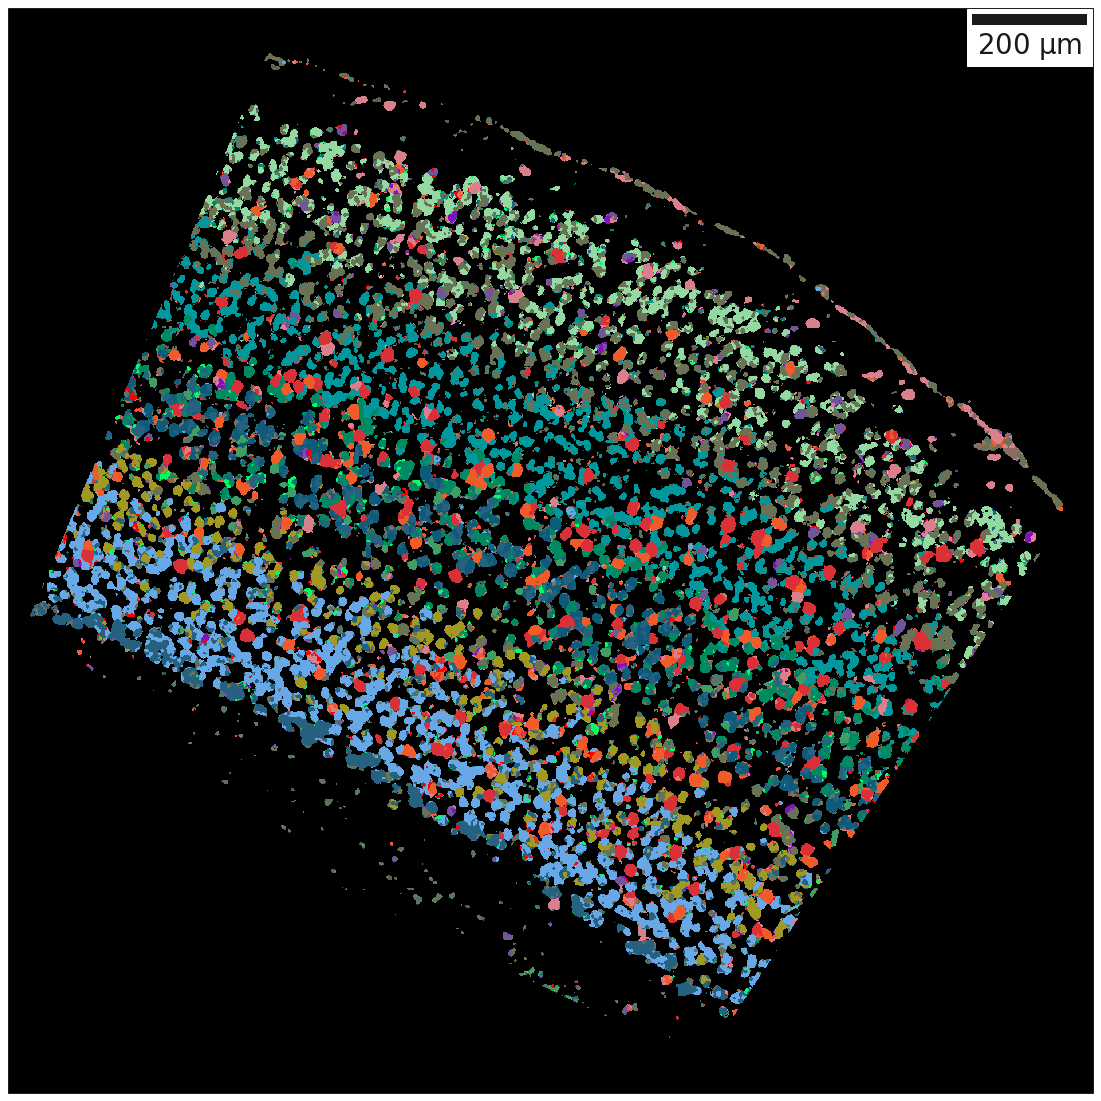

In [233]:
plt.figure(figsize=[20, 20])
ds.plot_celltypes_map(rotate=1, colors=scrna_colors, set_alpha=False)
plt.xlim([2050, 150])
plt.ylim([2050, 150])
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
scalebar = ScaleBar(1, 'um') # 1 pixel = 1um
plt.gca().add_artist(scalebar)

## SSAM *de novo* mode

Cluster vectors

In [241]:
analysis.cluster_vectors(min_cluster_size=2, pca_dims=22, resolution=0.15, metric='correlation', subclustering=True)

Found 49 clusters


Generate cell type maps

In [27]:
analysis.map_celltypes()
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.6, output_mask=output_mask)

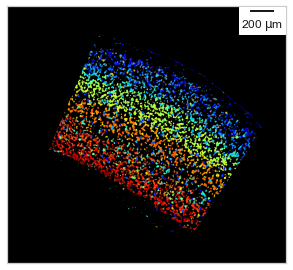

In [18]:
plt.figure(figsize=[5, 5])
ds.plot_celltypes_map(rotate=1)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
scalebar = ScaleBar(1, 'um') # 1 pixel = 1um
plt.gca().add_artist(scalebar)
plt.show()

Draw embedding

In [30]:
# Load precomputed tSNE
load_tsne("all_excluded_2d")

(-47.90947074890137, 61.945031356811526, -49.65810928344727, 56.77258071899414)

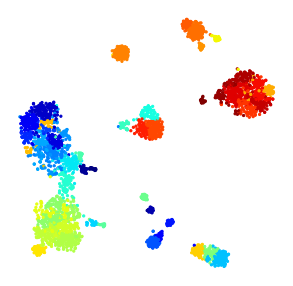

In [30]:
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=22, metric="correlation", s=5, run_tsne=False)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.axis('off')

Draw diagnostic plots

In [34]:
    def plot_diagnostic_plot(self, centroid_index, cluster_name=None, cluster_color=None, cmap=None, rotate=0, z=None, use_embedding="tsne", known_signatures=[], correlation_methods=[]):
        """
        Plot the diagnostic plot. This method requires `plot_tsne` or `plot_umap` was run at least once before.

        :param centroid_index: Index of the centroid for the diagnostic plot.
        :type centroid_index: int
        :param cluster_name: The name of the cluster.
        :type cluster_name: str
        :param cluster_color: The color of the cluster. Overrides `cmap` parameter.
        :type cluster_color: str or list(float)
        :param cmap: The colormap for the clusters. The cluster color is determined using the `centroid_index` th color of the given colormap.
        :type cmap: str or matplotlib.colors.Colormap
        :param rotate: Rotate the plot. Possible values are 0, 1, 2, and 3.
        :type rotate: int
        :param z: Z index to slice 3D vector norm and cell-type map plots.
            If not given, the slice at the middle will be used.
        :type z: int
        :param use_embedding: The type of the embedding for the last panel. Possible values are "tsne" or "umap".
        :type use_embedding: str
        :param known_signatures: The list of known signatures, which will be displayed in the 3rd panel. Each signature can be 3-tuple or 4-tuple,
            containing 1) the name of signature, 2) gene labels of the signature, 3) gene expression values of the signature, 4) optionally the color of the signature.
        :type known_signatures: list(tuple)
        :param correlation_methods: The correlation method used to determine max correlation of the centroid to the `known_signatures`. Each method should be 2-tuple,
            containing 1) the name of the correaltion, 2) the correaltion function (compatiable with the correlation methods available in `scipy.stats <https://docs.scipy.org/doc/scipy/reference/stats.html>`_)
        :type correlation_methods: list(tuple)
        """
        if z is None:
            z = int(self.vf_norm.shape[2] / 2)
        p, e = self.centroids[centroid_index], self.centroids_stdev[centroid_index]
        if cluster_name is None:
            cluster_name = "Cluster #%d"%centroid_index
        
        if cluster_color is None:
            if cmap is None:
                cmap = plt.get_cmap("jet")
            cluster_color = cmap(centroid_index / (len(self.centroids) - 1))

        if len(correlation_methods) == 0:
            correlation_methods = [("r", corr), ]
        total_signatures = len(correlation_methods) * len(known_signatures) + 1
                
        ax = plt.subplot(1, 4, 1)
        mask = self.filtered_cluster_labels == centroid_index
        plt.scatter(self.local_maxs[0][mask], self.local_maxs[1][mask], c=[cluster_color])
        self.plot_l1norm(rotate=rotate, cmap="Greys", z=z)

        ax = plt.subplot(1, 4, 2)
        ctmap = np.zeros([self.filtered_celltype_maps.shape[0], self.filtered_celltype_maps.shape[1], 4])
        ctmap[self.filtered_celltype_maps[..., z] == centroid_index] = to_rgba(cluster_color)
        ctmap[np.logical_and(self.filtered_celltype_maps[..., z] != centroid_index, self.filtered_celltype_maps[..., 0] > -1)] = [0.9, 0.9, 0.9, 1]
        if rotate == 1 or rotate == 3:
            ctmap = ctmap.swapaxes(0, 1)
        ax.imshow(ctmap, interpolation='nearest')
        if rotate == 1:
            ax.invert_xaxis()
        elif rotate == 2:
            ax.invert_xaxis()
            ax.invert_yaxis()
        elif rotate == 3:
            ax.invert_yaxis()

        ax = plt.subplot(total_signatures, 4, 3)
        ax.bar(self.genes, p, yerr=e)
        ax.set_title(cluster_name)
        plt.xlim([-1, len(self.genes)])
        plt.xticks(rotation=90)

        subplot_idx = 0
        for signature in known_signatures:
            sig_title, sig_labels, sig_values = signature[:3]
            sig_colors_defined = False
            if len(signature) == 4:
                sig_colors = signature[3]
                sig_colors_defined = True
            for corr_label, corr_func in correlation_methods:
                corr_results = [corr_func(p, sig_value) for sig_value in sig_values]
                corr_results = [e[0] if hasattr(e, "__getitem__") else e for e in corr_results]
                max_corr_idx = np.argmax(corr_results)
                ax = plt.subplot(total_signatures, 4, 7+subplot_idx*4)
                lbl = sig_labels[max_corr_idx]
                if sig_colors_defined:
                    col = sig_colors[max_corr_idx]
                else:
                    col = cluster_color
                ax.bar(self.genes, sig_values[max_corr_idx], color=col)
                ax.set_title("%s in %s (max %s, %.3f)"%(lbl, sig_title, corr_label, corr_results[max_corr_idx]))
                plt.xlim([-1, len(self.genes)])
                plt.xticks(rotation=90)
                subplot_idx += 1

        if use_embedding == 'tsne':
            embedding = self.tsne
            fig_title = "t-SNE, %d vectors"%sum(self.filtered_cluster_labels == centroid_index)
        elif use_embedding == 'umap':
            embedding = self.umap
            fig_title = "UMAP, %d vectors"%sum(self.filtered_cluster_labels == centroid_index)
        good_vectors = self.filtered_cluster_labels[self.filtered_cluster_labels != -1]
        ax = plt.subplot(1, 4, 4)
        ax.scatter(embedding[:, 0][good_vectors != centroid_index], embedding[:, 1][good_vectors != centroid_index], c=[[0.8, 0.8, 0.8, 1],], s=80)
        ax.scatter(embedding[:, 0][good_vectors == centroid_index], embedding[:, 1][good_vectors == centroid_index], c=[cluster_color], s=80)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(fig_title)

In [312]:
ds.normalized_vectors[ds.filtered_cluster_labels > -1].shape

(4113, 22)

In [36]:
from scipy.stats import pearsonr, spearmanr

for idx in range(len(ds.centroids)):
    plt.figure(figsize=[50, 15])
    plot_diagnostic_plot(ds, idx, known_signatures=[
        ("scRNA-seq", scrna_uniq_labels, scrna_centroids, scrna_colors),
    ], correlation_methods=[
        ("r", pearsonr),
        ("rho", spearmanr)
    ], rotate=1)
    plt.tight_layout()
    plt.savefig('diagplots_multiplexed_smFISH/diagplot_centroid_%d.png'%idx)
    plt.close()

Merge/remove clusters

In [242]:
denovo_labels = [
    "N/A",
    "VLMC",
    "Vip Arhgap36 Hmcn1 / Vip Igfbp4 Map21l1",
    "L2/3 IT Rrad",
    "L2/3 IT Rrad",
    "L2/3 IT Rrad",
    "Sst Nts / Sst Rxfp1 Eya1",
    "Lamp5 Lsp1",
    "L2/3 IT Rrad",
    "L2/3 IT Rrad",

    "Sst Crhr2 Efemp1",
    "Sst Chodl",
    "L2/3 IT Rrad",
    "L2/3 IT Rrad",
    "L2/3 IT Rrad",
    "Pvalb Gpr149 Islr / Pvalb Reln Tac1",
    "Astro Aqp4",
    "L2/3 IT Agmat",
    "L6 IT Col23a1 Adamts2",
    "L4 IT Superficial",
    
    "L5 IT Col27a1",
    "L2/3 IT Agmat",
    "OPC",
    "Oligo",
    "Pvalb Calb1 Sst / Pvalb Sema3e Kank4",
    "L4 IT Rspo1",
    "L4 IT Rspo1",
    "L4 IT Rspo1",
    "L4 IT Rspo1",
    "L4 IT Rspo1",
    
    "L4 IT Rspo1",
    "L5 NP Trhr Met",
    "L5 IT Hsd11b1 Endou",
    "Pvalb Th Sst / Pvalb Reln Tac1",
    "L2/3 IT Rrad",
    "L6 CT Ctxn3 Brinp3",
    "L5 PT Chrna6",
    "L5 IT Batf3",
    "L5 PT C1ql2 Cdh13",
    "L5 PT Krt80",
    
    "L6 IT Penk Col27a1",
    "L6 CT Ctxn3 Brinp3",
    "L6 IT Penk Col27a1",
    "L6 CT Ctxn3 Brinp3",
    "L6 CT Ctxn3 Brinp3",
    "L6 CT Ctxn3 Brinp3",
    "L6 CT Ctxn3 Brinp3",
    "L6b Col8a1 Rprm",
    "L6b Crh",
]

In [243]:
denovo_labels_final = []
exclude_indices = []
merge_indices = []

for idx, cl in enumerate(denovo_labels):
    if cl == 'N/A':
        exclude_indices.append(idx)
        continue
    if cl in denovo_labels_final:
        continue
    denovo_labels_final.append(cl)

for cl in np.unique(denovo_labels):
    if cl == 'N/A':
        continue
    mask = [cl == e for e in denovo_labels]
    if np.sum(mask) > 1:
        merge_indices.append(np.where(mask)[0])

(-47.91387876821185, 61.94943937612201, -49.66263407148121, 56.77710550702808)

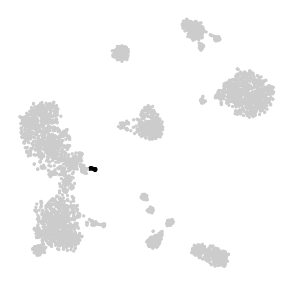

In [31]:
# Plot removed clusters in tSNE
cmap = plt.get_cmap('jet')
jet_colors = cmap(np.array(list(range(len(ds.centroids)))) / (len(ds.centroids) - 1))
tsne_colors = np.zeros_like(jet_colors)
tsne_colors[..., :] = [0.8, 0.8, 0.8, 1]
tsne_colors[exclude_indices] = [0, 0, 0, 1] #jet_colors[exclude_indices]
import matplotlib.patheffects as PathEffects
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False, colors=tsne_colors)
plt.axis('off')

(-48.39801856907897,
 62.43357917698911,
 -50.144083453029204,
 57.258554888576086)

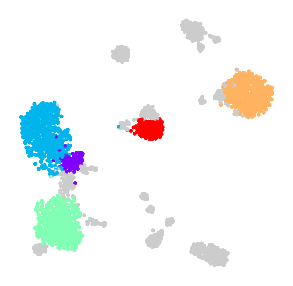

In [32]:
# Plot merged clusters in tSNE
cmap = plt.get_cmap('rainbow')
jet_colors = cmap(np.array(list(range(len(merge_indices)))) / (len(merge_indices) - 1))
plt.figure(figsize=[5, 5])
tsne_colors = np.zeros([len(ds.centroids), 4])
tsne_colors[..., :] = [0.8, 0.8, 0.8, 1]
for idx, mi in enumerate(merge_indices):
    tsne_colors[mi] = jet_colors[idx]
    ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False, colors=tsne_colors)
plt.axis('off')

In [244]:
analysis.exclude_and_merge_clusters(exclude_indices, merge_indices, centroid_correction_threshold=0.6)

/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/ssam-1.0.1-py3.8-linux-x86_64.egg/ssam/__init__.py:1203: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  merge = np.array(merge)


Draw cell-type map

In [303]:
# Borrow clutster colors from scRNA-seq data
import matplotlib
denovo_cellclass_colors = []
denovo_celltype_colors = []
cluster_col_dic = dict(scrna_cl_metadata_dic.values())
for lbl in denovo_labels_final:
    if ' / ' in lbl:
        lbl = lbl.split(' / ')[0].rstrip()
    if lbl == 'VLMC':
        lbl = 'VLMC Spp1 Hs3st6'
    elif lbl == 'OPC':
        lbl = 'OPC Pdgfra Grm5'
    elif lbl == 'Oligo':
        lbl = 'Oligo Serpinb1a'
    elif lbl == 'L6b Crh':
        lbl = 'L6b VISp Crh'
    if ' IT ' in lbl:
        lbl = lbl.replace(' IT ', ' IT VISp ')
    elif ' NP ' in lbl:
        lbl = lbl.replace(' NP ', ' NP VISp ')
    elif ' CT ' in lbl:
        lbl = lbl.replace(' CT ', ' CT VISp ')
    elif ' PT ' in lbl:
        lbl = lbl.replace(' PT ', ' PT VISp ')
    if lbl == "L4 IT VISp Superficial":
        col = '#9900B3'
    else:
        col = cluster_col_dic[lbl]
    denovo_celltype_colors.append(col)
    
    s = lbl.split(" ")
    cl = s[0]
    if cl in ["PVM", "Microglia"]:
        cl = "Macrophage"
    if s[1] in ["IT", "CT", "NP", "PT"]:
        cl += " " + s[1]
    if cl == "OPC":
        cl = "Oligo"
    denovo_cellclass_colors.append(cell_class_colors[cl])

In [245]:
analysis.map_celltypes()
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.6, fill_blobs=True, min_blob_area=50, output_mask=output_mask)

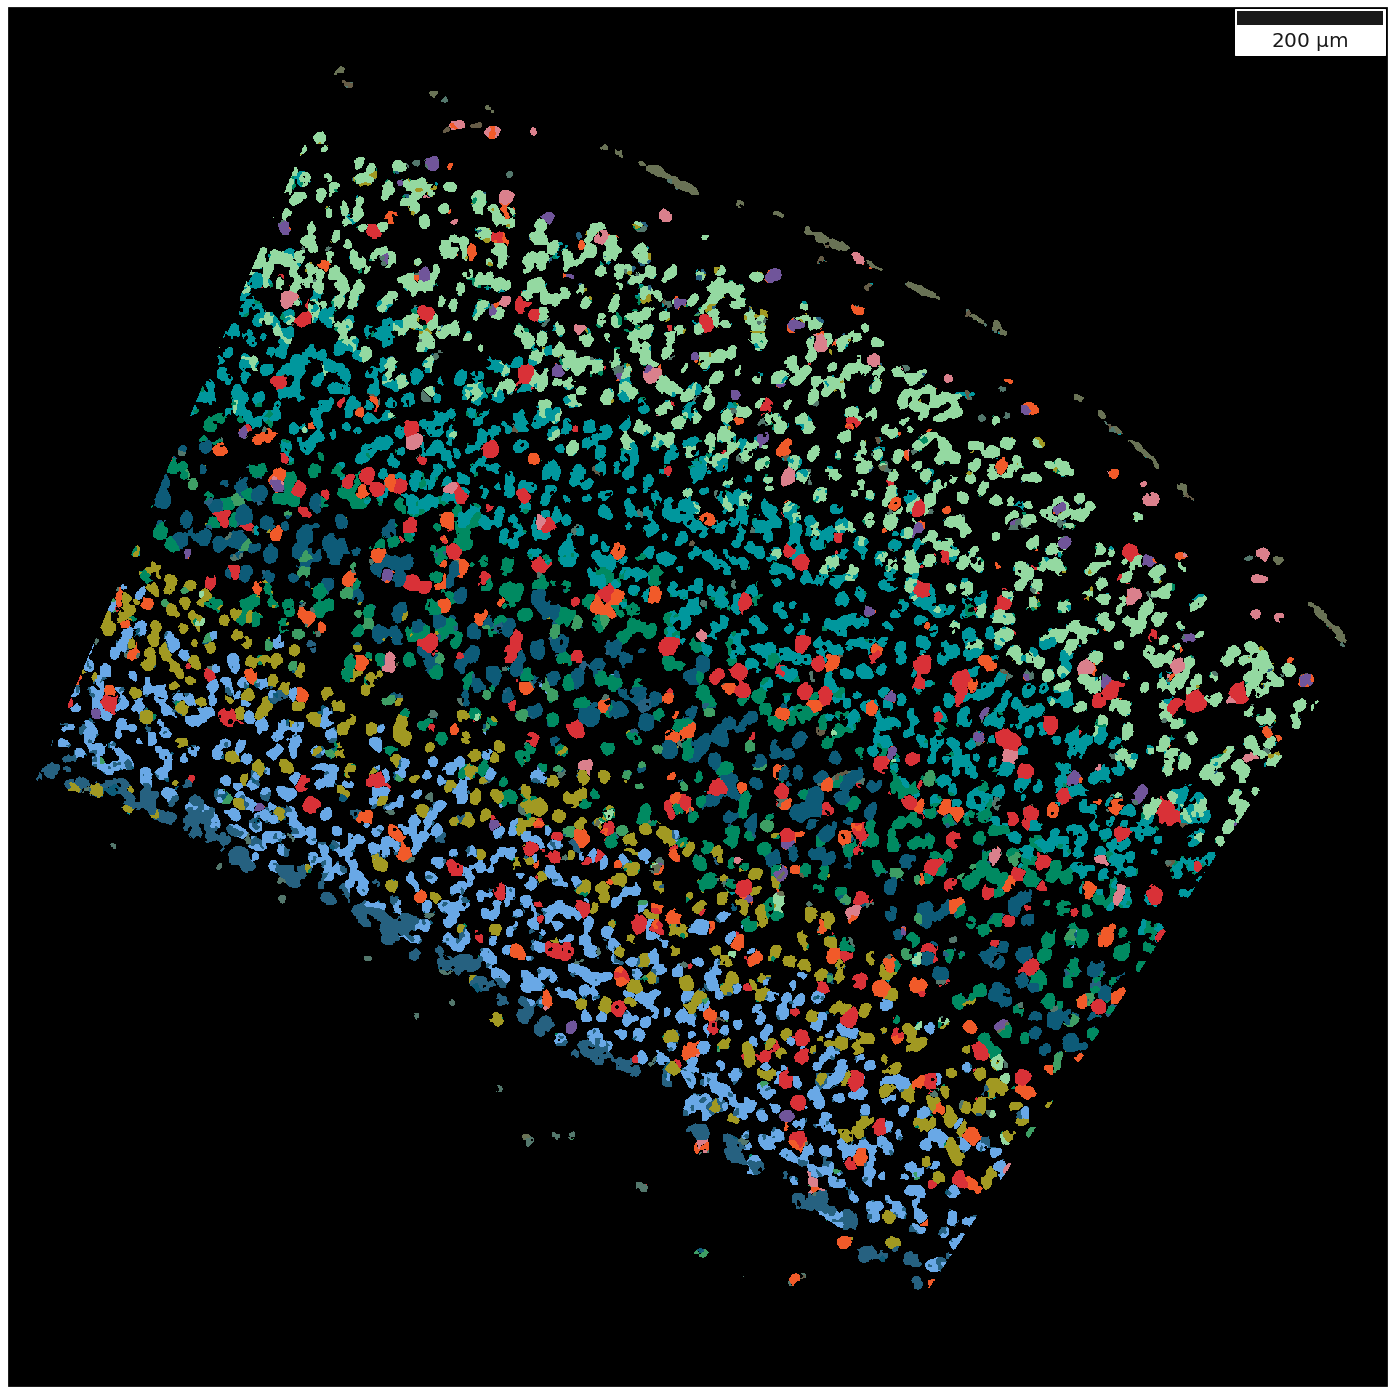

In [299]:
plt.figure(figsize=[20, 20])
ds.plot_celltypes_map(colors=denovo_cellclass_colors, rotate=1, set_alpha=False)
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.xlim([2050, 150])
plt.ylim([2050, 150])
plt.tight_layout()

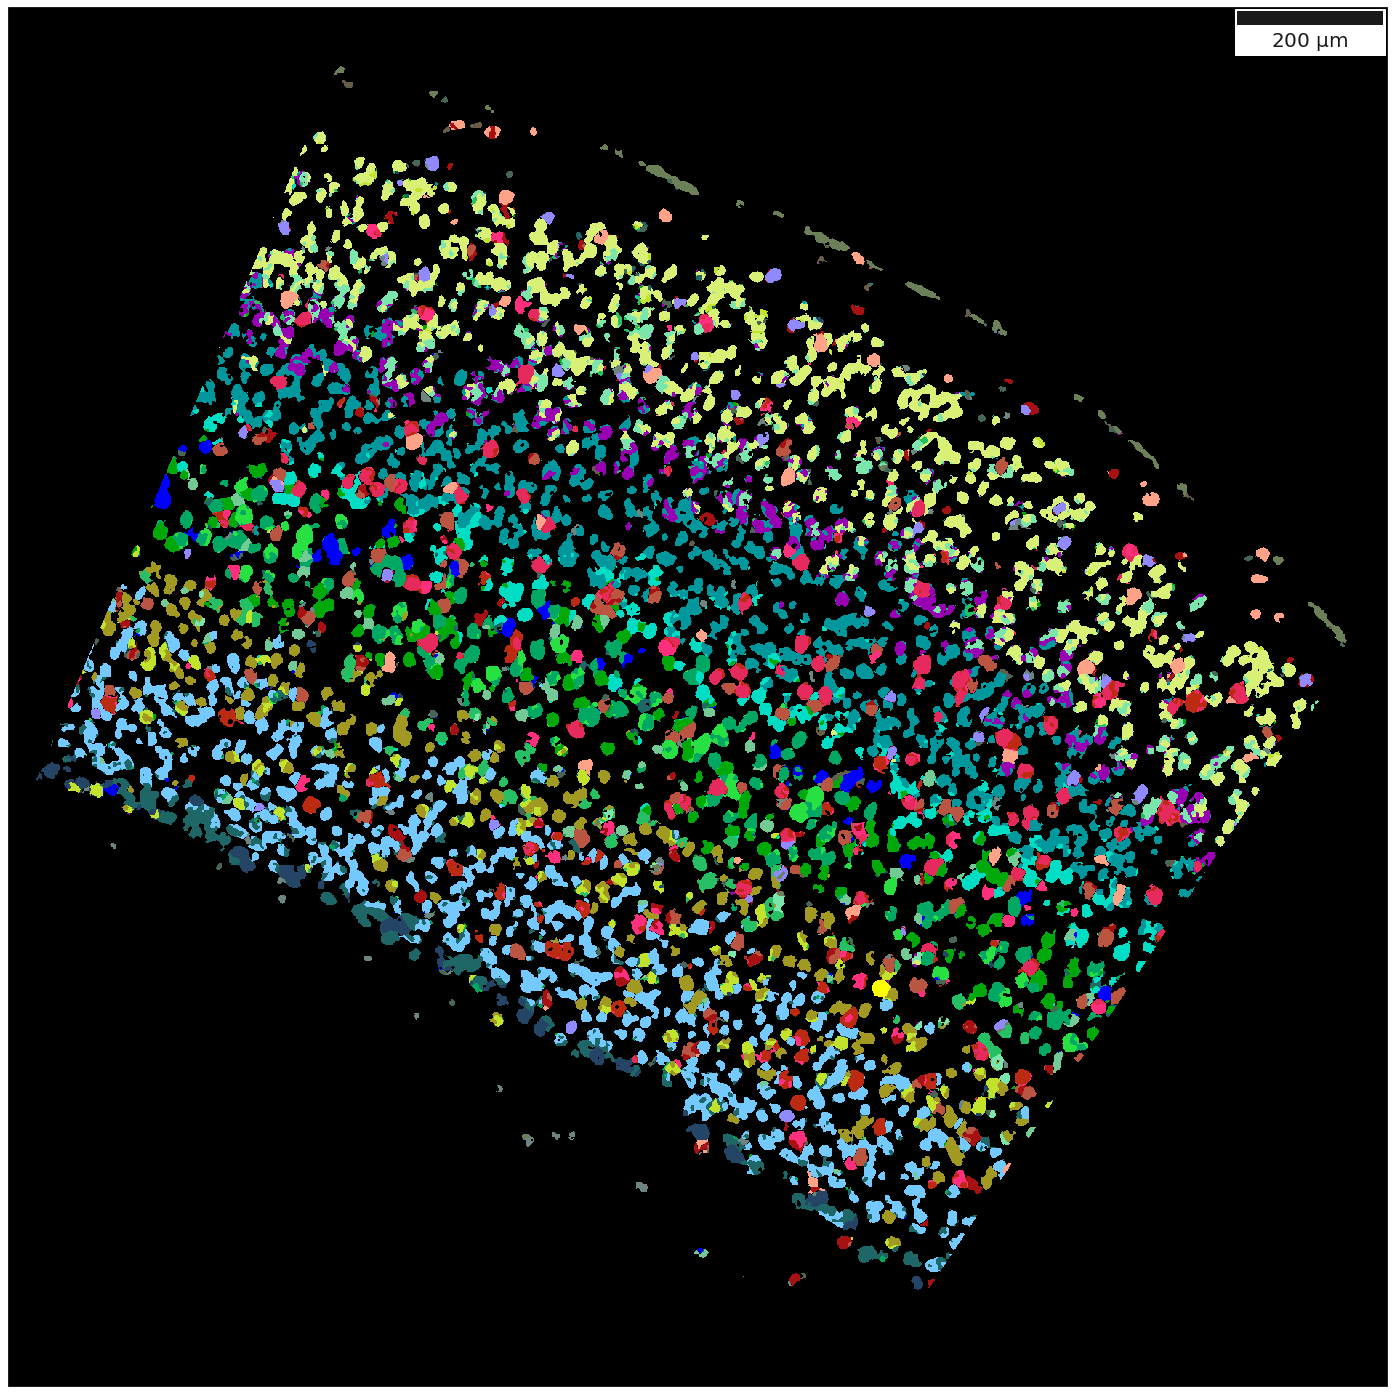

In [304]:
plt.figure(figsize=[20, 20])
ds.plot_celltypes_map(colors=denovo_celltype_colors, rotate=1, set_alpha=False)
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.xlim([2050, 150])
plt.ylim([2050, 150])
plt.tight_layout()

In [305]:
dc_cols = np.zeros_like(denovo_celltype_colors)
dc_cols[:] = "#cccccc"
dc_cols[11] = denovo_celltype_colors[11]
dc_cols[16] = denovo_celltype_colors[16]

Heterogeneity in L4

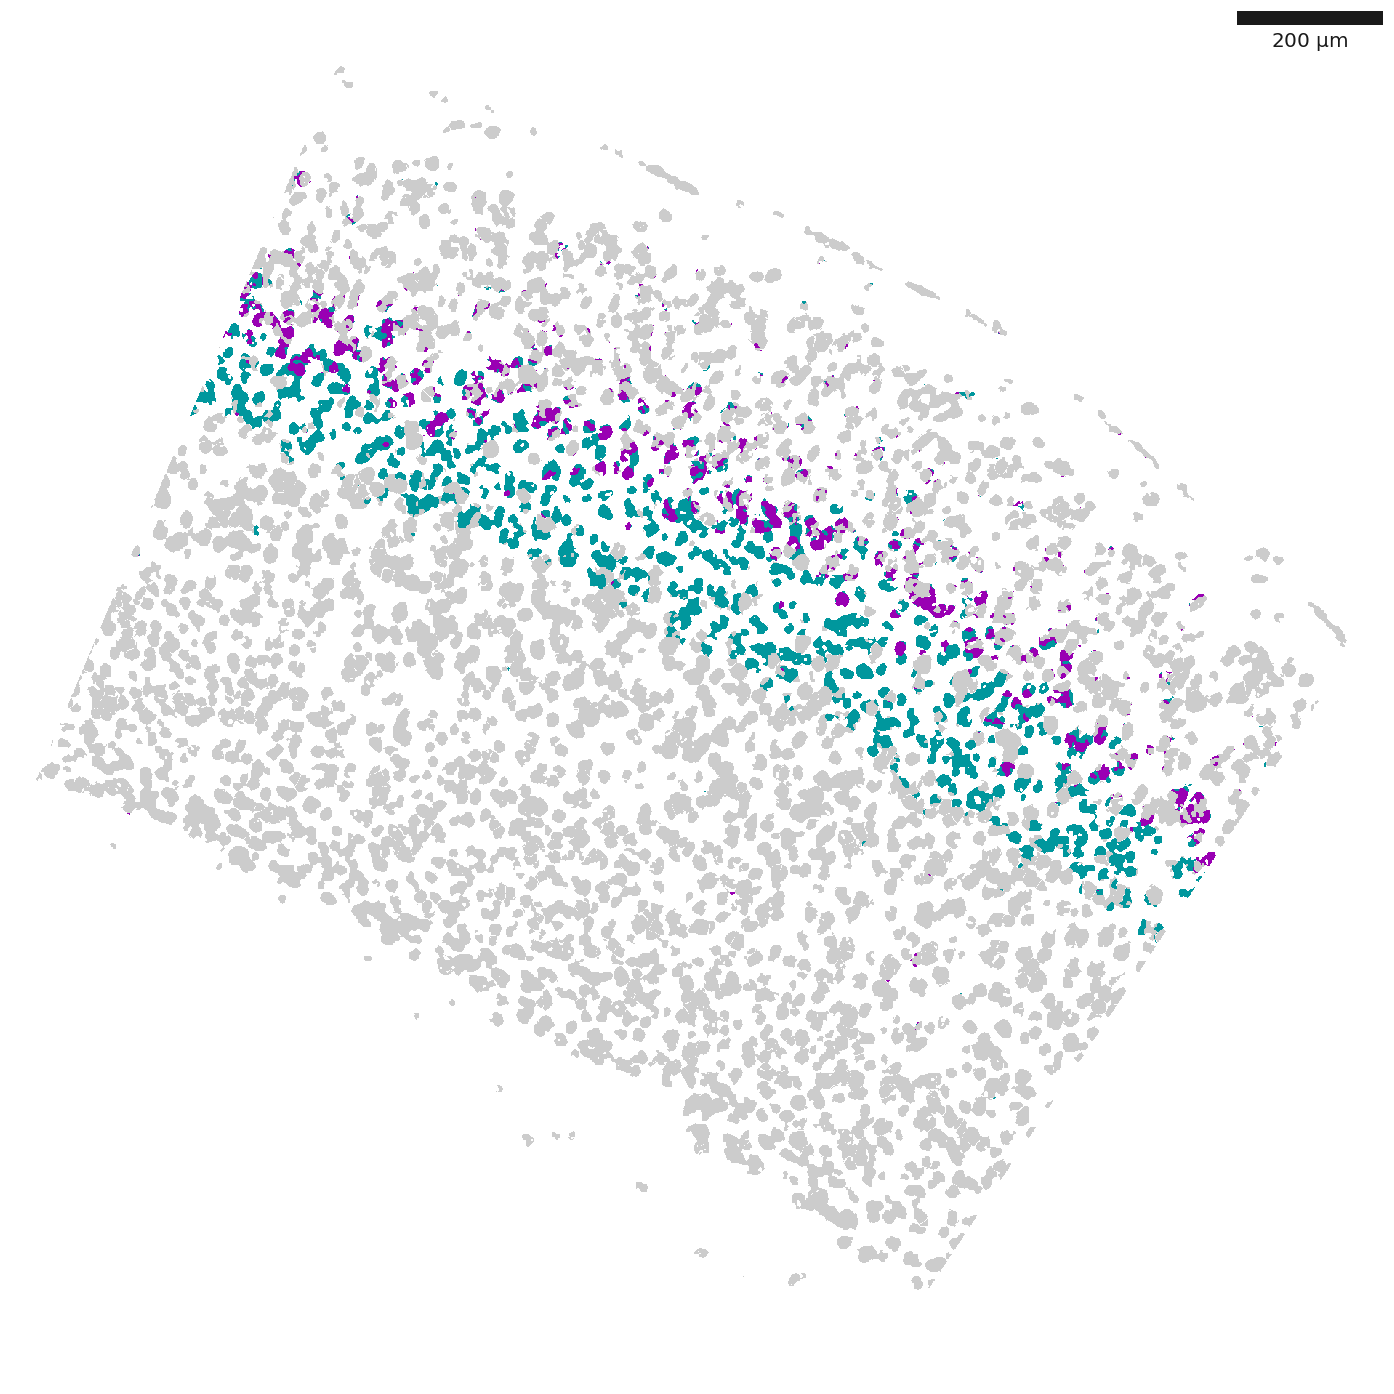

In [306]:
plt.figure(figsize=[20, 20])
ds.plot_celltypes_map(background='white', colors=dc_cols, rotate=1, set_alpha=False)
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.xlim([2050, 150])
plt.ylim([2050, 150])
plt.tight_layout()

In [249]:
dc_cols = np.zeros_like(denovo_celltype_colors)
dc_cols[:] = "#cccccc"
dc_cols[6] = denovo_celltype_colors[6]

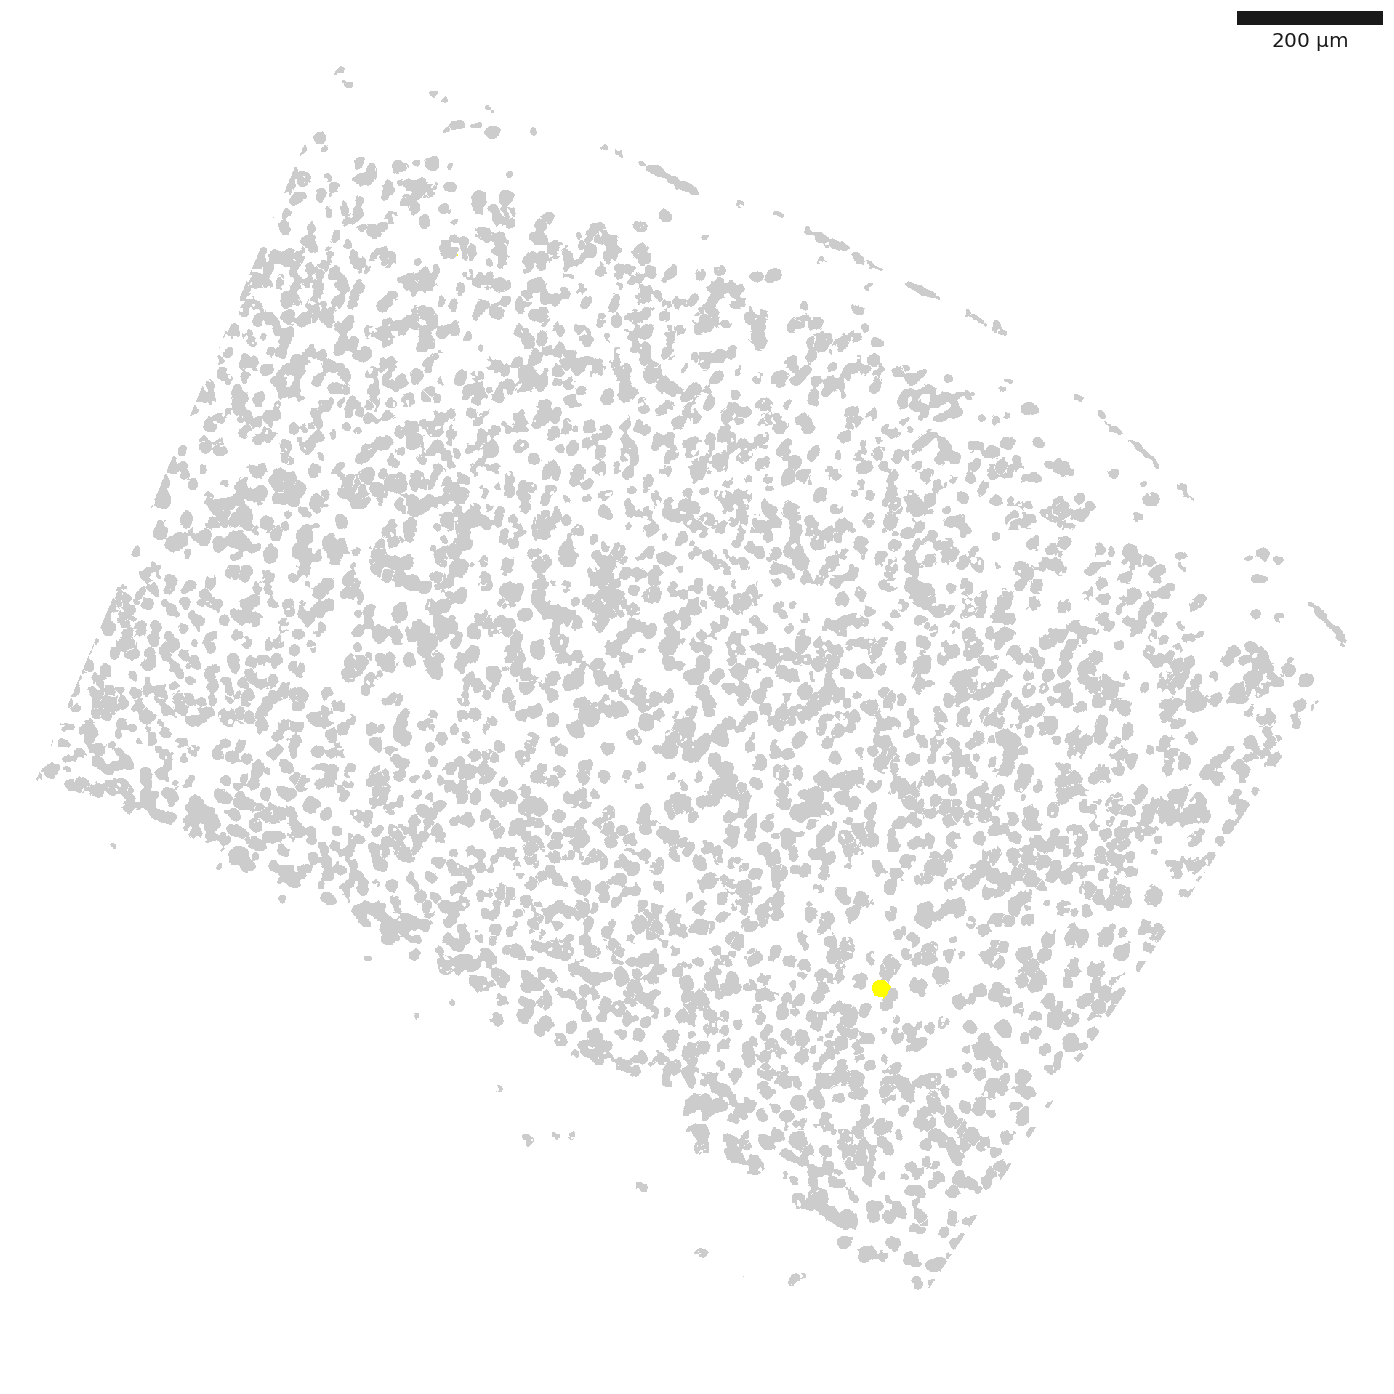

In [250]:
plt.figure(figsize=[20, 20])
ds.plot_celltypes_map(background='white', colors=dc_cols, rotate=1, set_alpha=False)
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.xlim([2050, 150])
plt.ylim([2050, 150])
plt.tight_layout()

Draw vector vs genes heatmap

In [39]:
# Reorder clusters according to dendrogram order of Tasic et al. (2018)
import matplotlib
heatmap_clusters_dend_index = []
for cl in denovo_labels_final:
    if ' / ' in cl:
        cl = cl.split(' / ')[0].rstrip()
    if cl == 'VLMC':
        cl = 'VLMC Spp1 Hs3st6'
    elif cl == 'OPC':
        cl = 'OPC Pdgfra Grm5'
    elif cl == 'Oligo':
        cl = 'Oligo Serpinb1a'
    elif cl == 'L6b Crh':
        cl = 'L6b VISp Crh'
    if ' IT ' in cl:
        cl = cl.replace(' IT ', ' IT VISp ')
    elif ' NP ' in cl:
        cl = cl.replace(' NP ', ' NP VISp ')
    elif ' CT ' in cl:
        cl = cl.replace(' CT ', ' CT VISp ')
    elif ' PT ' in cl:
        cl = cl.replace(' PT ', ' PT VISp ')
    if cl == "L4 IT VISp Superficial":
        cl = 'L4 IT VISp Rspo1'
    heatmap_clusters_dend_index.append(dendrogram_order.index(cl))
heatmap_clusters_index = np.argsort(heatmap_clusters_dend_index)
heatmap_clusters_ordered = np.array(denovo_labels_final)[heatmap_clusters_index]

In [40]:
# Shorten the cluster labels
denovo_labels_final_short = [
    'VLMC',
    'Vip',
    'L2/3 IT 1',
    'Sst 3',
    'Lamp5',
    'Sst 2',
    'Sst 1',
    'Pvalb 2',
    'Astro',
    'L2/3 IT 2',
    'L6 IT 2',
    'L4 IT 2',
    'L5 IT 3',
    'OPC',
    'Oligo',
    'Pvalb 3',
    'L4 IT 1',
    'L5 NP',
    'L5 IT 1',
    'Pvalb 1',
    'L6 CT',
    'L5 PT 1',
    'L5 IT 2',
    'L5 PT 2',
    'L5 PT 3',
    'L6 IT 1',
    'L6b 1',
    'L6b 2',
]
to_short = dict(zip(denovo_labels_final, denovo_labels_final_short))
heatmap_clusters_ordered_short = [to_short[cl] for cl in heatmap_clusters_ordered]

In [196]:
pd.DataFrame(list(zip(heatmap_clusters_ordered_short, heatmap_clusters_ordered)))

,0,1
0,L2/3 IT 1,L2/3 IT Rrad
1,L2/3 IT 2,L2/3 IT Agmat
2,L4 IT 1,L4 IT Rspo1
3,L4 IT 2,L4 IT Superficial
4,L5 IT 1,L5 IT Hsd11b1 Endou
5,L5 IT 2,L5 IT Batf3
6,L5 IT 3,L5 IT Col27a1
7,L6 IT 1,L6 IT Penk Col27a1
8,L6 IT 2,L6 IT Col23a1 Adamts2
9,L5 PT 1,L5 PT Chrna6


In [41]:
# Sort genes for heatmap
from matplotlib.colors import to_rgba, to_hex

heatmap_vectors = np.zeros([np.sum(ds.filtered_cluster_labels != -1), len(ds.genes)], dtype=float)
col_colors = np.zeros(np.sum(ds.filtered_cluster_labels != -1), dtype='<U7')
acc_idx = 0
acc_sizes = []

for cl_idx in heatmap_clusters_index:
    acc_idx = sum(acc_sizes)
    cl_vecs = ds.normalized_vectors[ds.filtered_cluster_labels == cl_idx]
    col = denovo_celltype_colors[cl_idx]
    heatmap_vectors[acc_idx:acc_idx+cl_vecs.shape[0], :] = cl_vecs
    col_colors[acc_idx:acc_idx+cl_vecs.shape[0]] = to_hex(col)
    acc_sizes.append(cl_vecs.shape[0])

heatmap_genes_index = []
heatmap_genes_ordered = []
_, i = np.unique(col_colors, return_index=True)
uc = col_colors[sorted(i)]
mean_genes = np.zeros([len(uc), len(ds.genes)])
for i, c in enumerate(uc):
    mean_genes[i, :] = np.mean(heatmap_vectors[col_colors == c], axis=0)

max_exp_indices = np.argmax(mean_genes, axis=0)
for i in range(len(uc)):
    cl_gene_indices = np.where(max_exp_indices == i)[0]
    heatmap_genes_index += list(cl_gene_indices)
    heatmap_genes_ordered += list(np.array(ds.genes)[cl_gene_indices])
heatmap_vectors = heatmap_vectors[:, heatmap_genes_index]

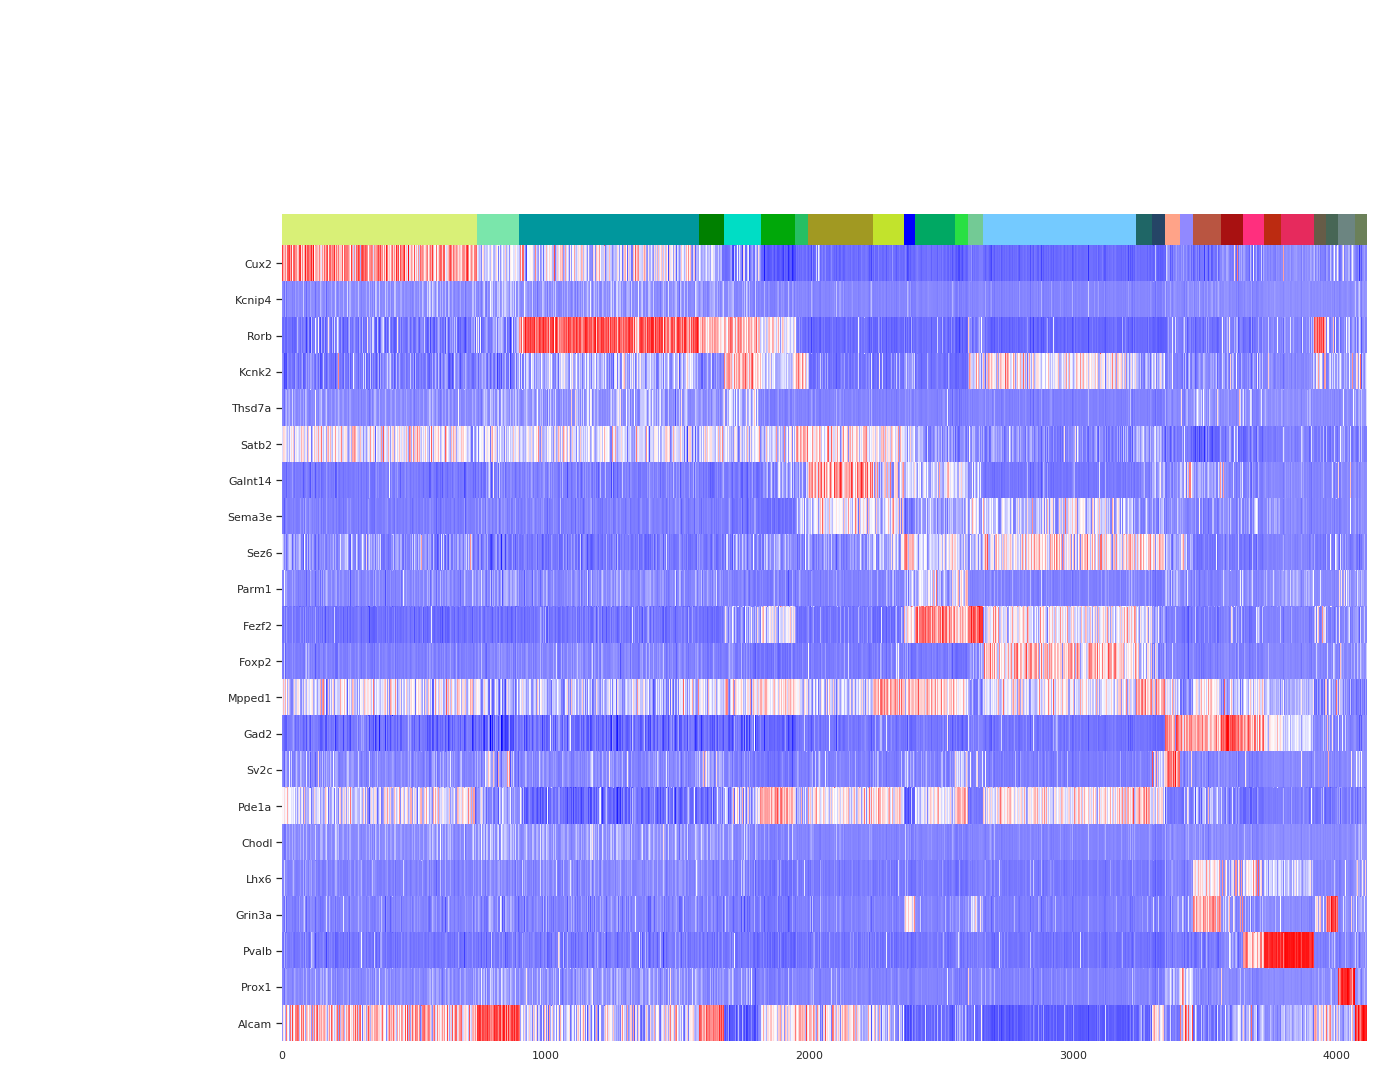

In [42]:
gene_exp_heatmap = heatmap_vectors.T
gene_exp_heatmap = preprocessing.scale(gene_exp_heatmap)
g = sns.clustermap(gene_exp_heatmap, figsize=[20, 15], yticklabels=heatmap_genes_ordered,
                 cmap='bwr', row_cluster=False, col_cluster=False,
                 col_colors=col_colors, xticklabels = 1000)
g.cax.set_visible(False)
g.ax_heatmap.tick_params(labelright=False, labelleft=True, right=False, left=True)

In [193]:
ds.normalized_vectors.shape

(4586, 22)

In [178]:
good_vectors = ds.vf[ds.local_maxs][ds.filtered_cluster_labels > -1]
import doubletdetection
clf = doubletdetection.BoostClassifier(use_phenograph=False, n_components=21) # use_phenograph causes error; setting this False to use Louvain clustering
labels = clf.fit(good_vectors).predict()

In [187]:
np.sum(labels == 1) / len(labels) * 100

0.468384074941452

In [186]:
import scrublet as scr
eps = np.finfo(float).eps
scrub = scr.Scrublet(good_vectors)
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=eps, min_cells=eps, min_gene_variability_pctl=eps, n_prin_comps=22)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 12.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.5%
Elapsed time: 1.4 seconds


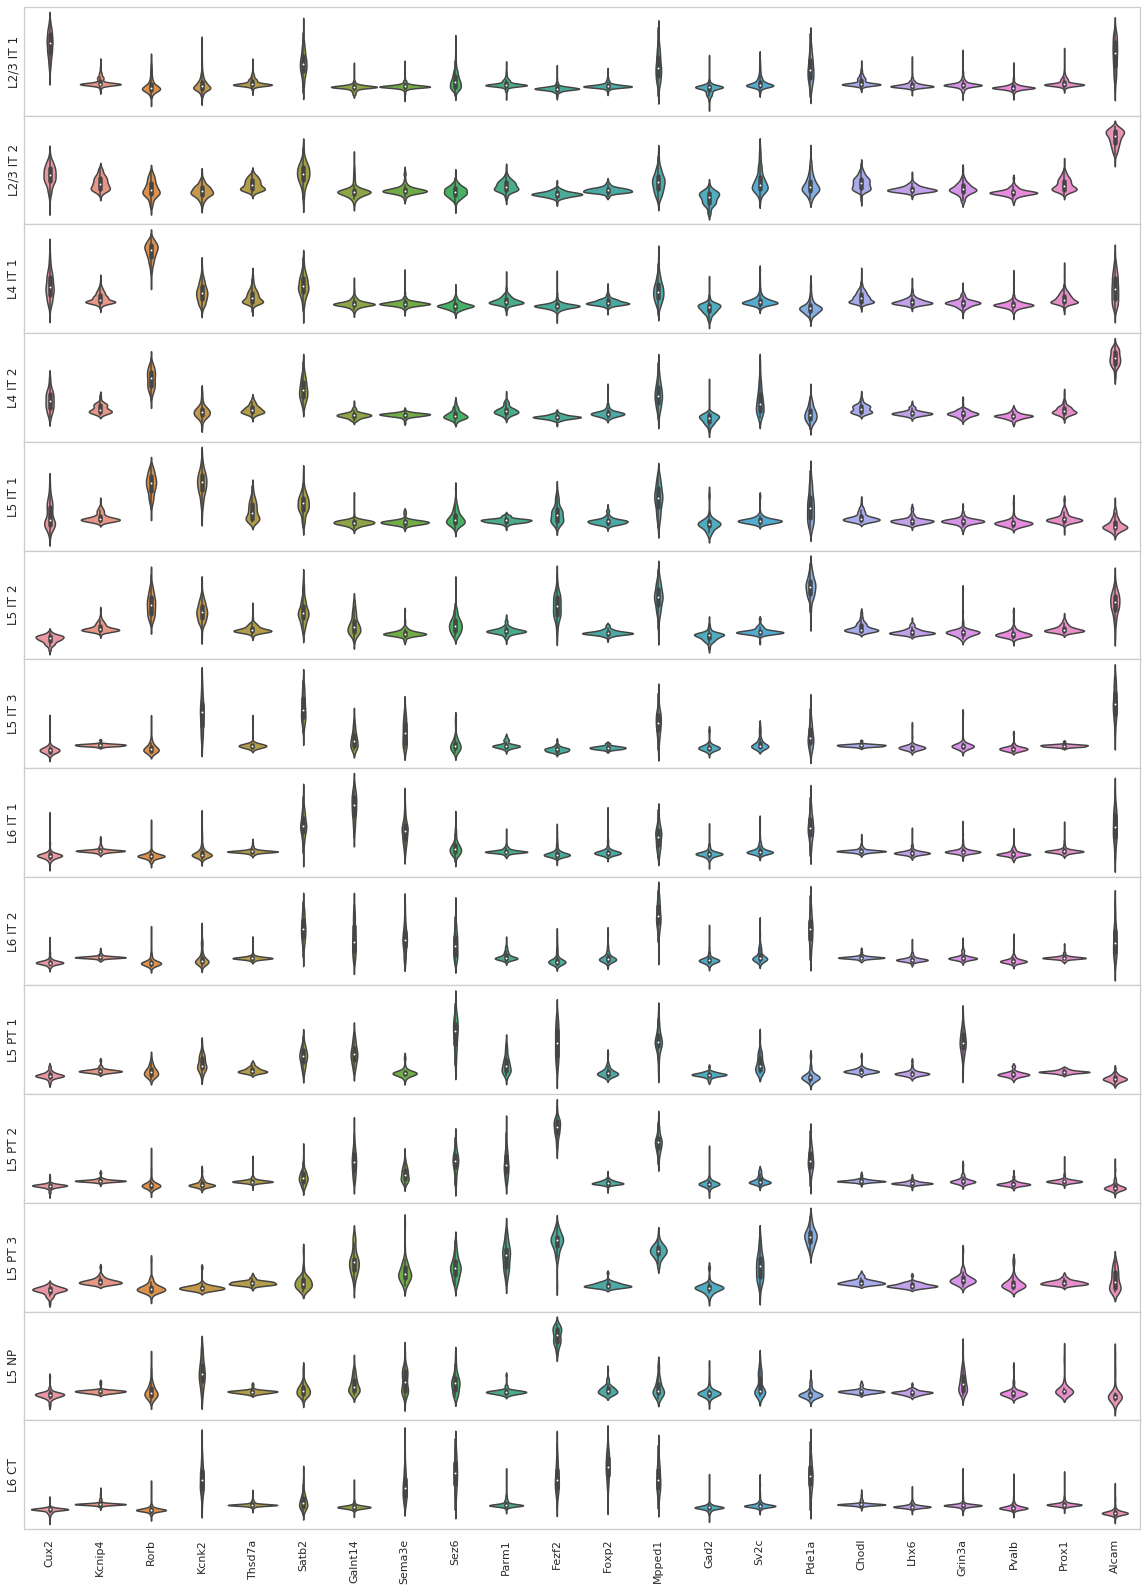

In [43]:
s = 0
e = 14

indices = heatmap_clusters_index[s:e]
acc_lens = acc_sizes[s:e]
acc_idx = sum(acc_sizes[:s])
ylabels = heatmap_clusters_ordered_short[s:e]

fig, axes = plt.subplots(len(indices), 1, figsize=[20, len(indices)*2])
plt.subplots_adjust(hspace=0)
for idx, acc_len in enumerate(acc_lens):
    cl_vecs = gene_exp_heatmap.T[acc_idx:acc_idx+acc_len]
    acc_idx += acc_len
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(ylabels[idx])
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(heatmap_genes_ordered, rotation=90)
pass

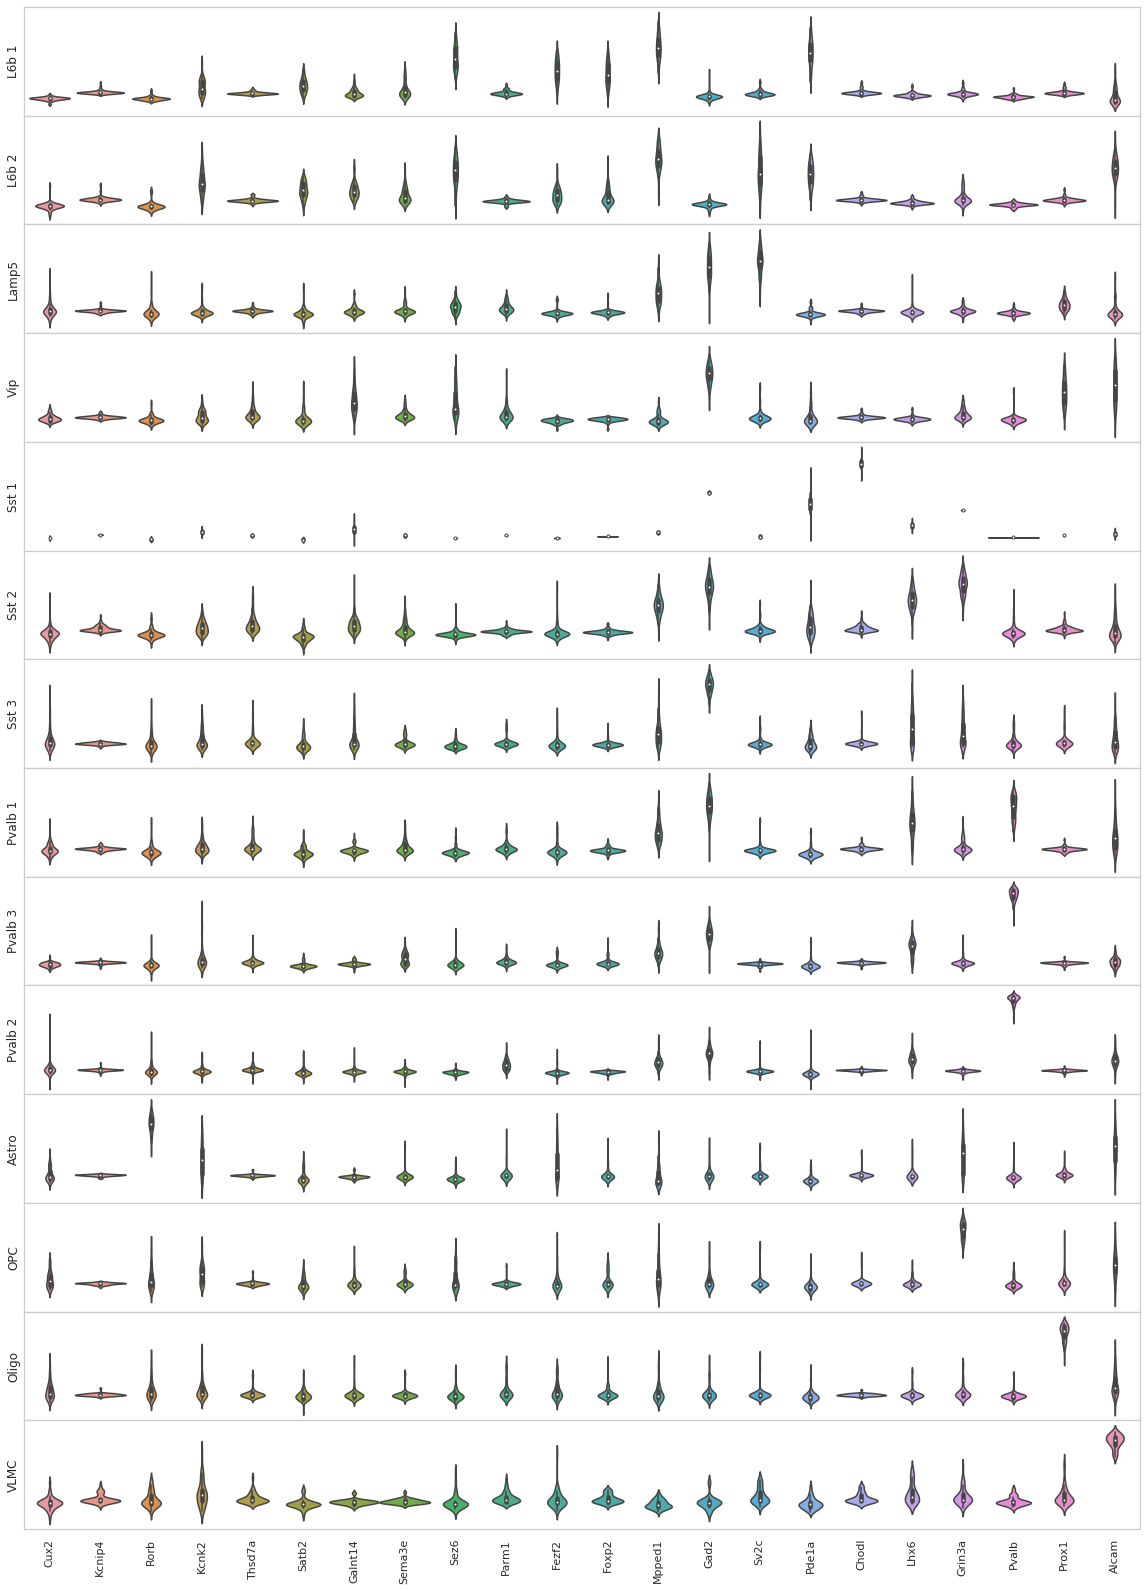

In [44]:
s = 14
e = None

indices = heatmap_clusters_index[s:e]
acc_lens = acc_sizes[s:e]
acc_idx = sum(acc_sizes[:s])
ylabels = heatmap_clusters_ordered_short[s:e]

fig, axes = plt.subplots(len(indices), 1, figsize=[20, len(indices)*2])
plt.subplots_adjust(hspace=0)
for idx, acc_len in enumerate(acc_lens):
    cl_vecs = gene_exp_heatmap.T[acc_idx:acc_idx+acc_len]
    acc_idx += acc_len
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(ylabels[idx])
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(heatmap_genes_ordered, rotation=90)
pass

Draw correlation plot, SSAM vs scRNA-seq

In [45]:
scrna_uniq_cluster_eng = [scrna_cl_metadata_dic[cl][0].strip() for cl in scrna_uniq_clusters]
heatmap_scrna_clusters_index = [scrna_uniq_cluster_eng.index(cl) for cl in dendrogram_order]

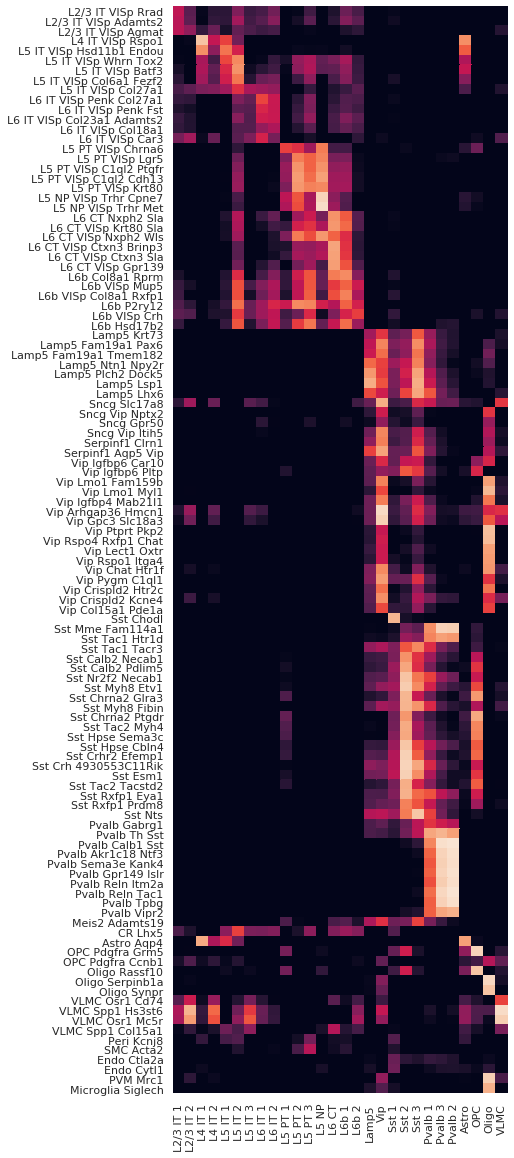

In [46]:
ssam_scrna_pcorrs_final = np.zeros((len(scrna_centroids), len(ds.centroids)))
for i, scrna_centroid in enumerate(scrna_centroids):
    for j, centroid in enumerate(ds.centroids):
        ssam_scrna_pcorrs_final[i, j] = ssam.utils.corr(scrna_centroid, centroid)

hm = ssam_scrna_pcorrs_final[:, heatmap_clusters_index][heatmap_scrna_clusters_index, :]

plt.figure(figsize=[6, 20])
sns.heatmap(hm, vmin=0, vmax=1, yticklabels=dendrogram_order, xticklabels=heatmap_clusters_ordered_short, cbar=False)

Draw tSNE

In [264]:
load_tsne("final_excluded_2d")

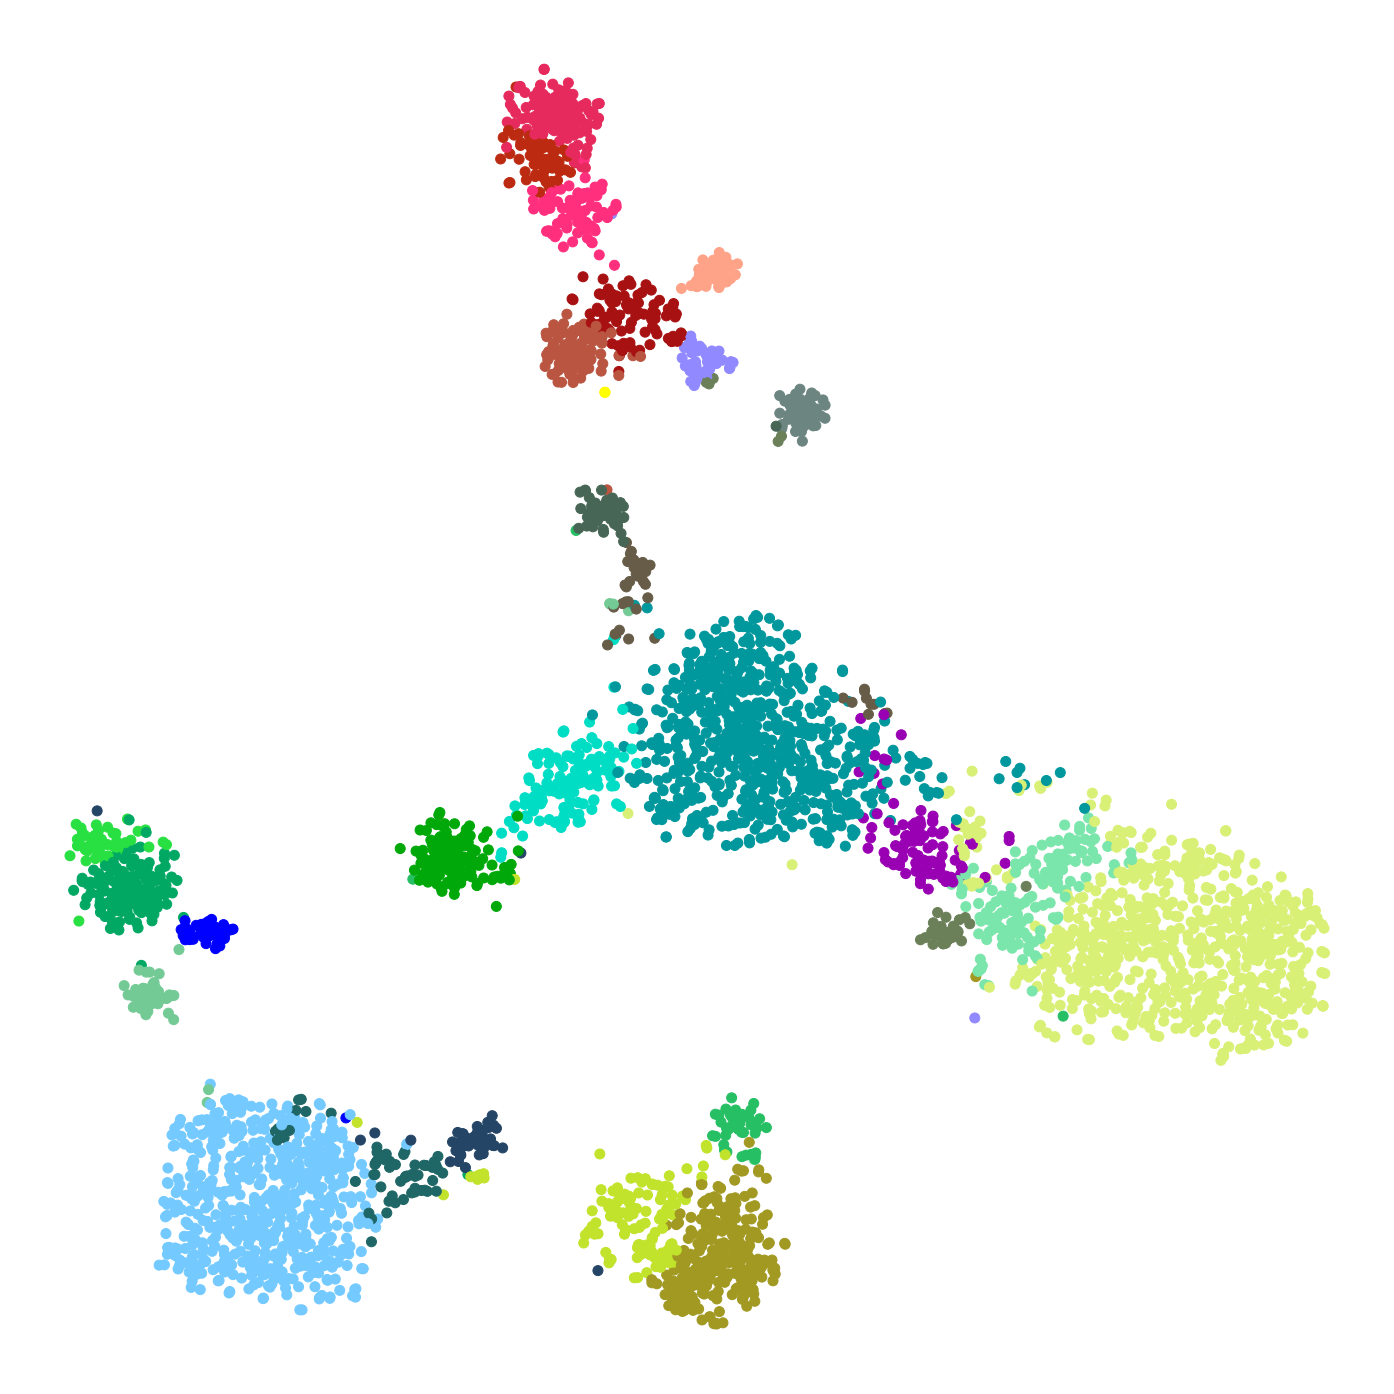

In [309]:
plt.figure(figsize=[20, 20])
ds.plot_tsne(pca_dims=22, metric="correlation", s=100, run_tsne=False, colors=denovo_celltype_colors)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().axis('off')
plt.tight_layout()

Plot diagnostic plot with the final result

In [55]:
for idx in range(len(ds.centroids)):
    plt.figure(figsize=[50, 15])
    ds.plot_diagnostic_plot(idx,
                            cluster_name=denovo_labels_final_short[idx],
                            cluster_color=denovo_celltype_colors[idx])
    plt.tight_layout()
    plt.savefig('diagplots_multiplexed_smFISH/diagplot_centroid_%d_after_merging_removing.png'%idx)
    plt.close()    

Infer domains in tissue

In [49]:
# Sweep circular window
analysis.bin_celltypemaps(step=10, radius=100)

In [50]:
analysis.find_domains(n_clusters=20, merge_remote=True, merge_thres=0.7, norm_thres=1500)

/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/matplotlib/colors.py:233: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


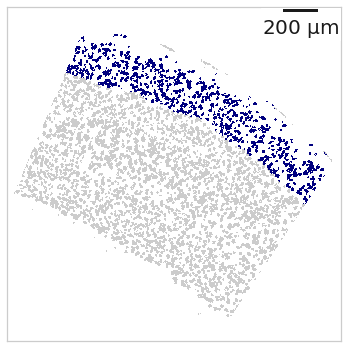

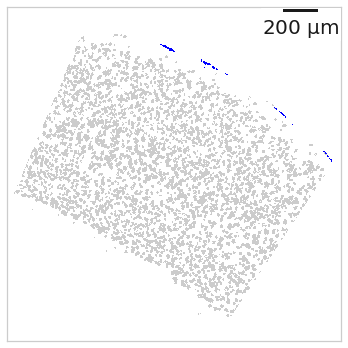

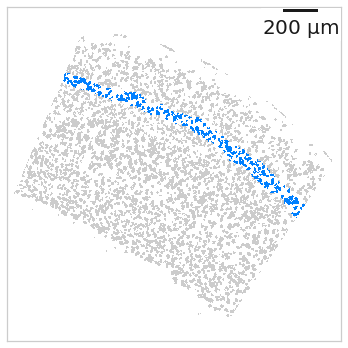

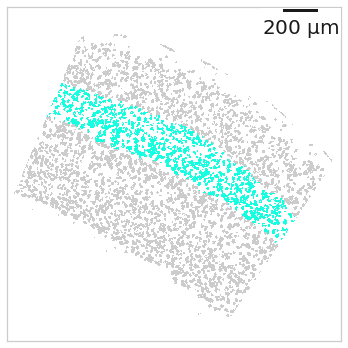

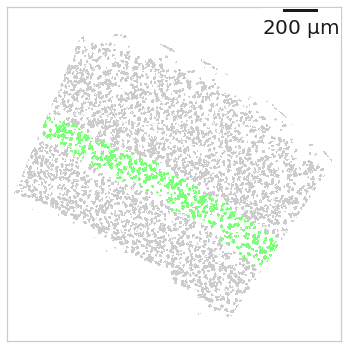

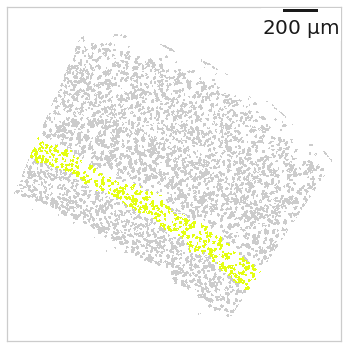

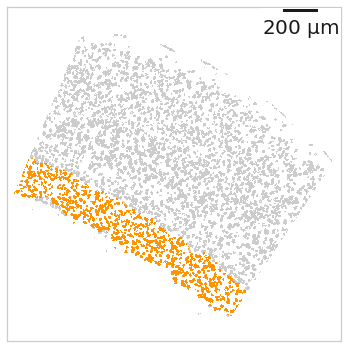

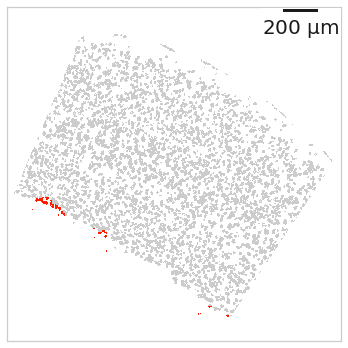

In [51]:
# Check found domains
from matplotlib.colors import ListedColormap
cmap_jet = plt.get_cmap('jet')
num_domains = np.max(ds.inferred_domains_cells) + 1
for domain_idx in range(num_domains):
    plt.figure(figsize=[5, 5])
    cmap = ListedColormap([cmap_jet(lbl_idx / num_domains) if domain_idx == lbl_idx else "#cccccc" for lbl_idx in range(num_domains)])
    ds.plot_domains(rotate=1, cmap=cmap)
    scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
    plt.gca().add_artist(scalebar)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.xlim([2050, 150])
    plt.ylim([2050, 150])
    plt.tight_layout()

In [54]:
excluded_domain_indices = []
merged_domain_indices = [(6, 7), ]

In [55]:
analysis.exclude_and_merge_domains(excluded_domain_indices, merged_domain_indices)

In [56]:
# Define domain colors
domain_colors = {
    'Pia': '#D44218',
    'Layer 1/2/3': '#85D7E4',
    'Layer 4': '#F6B813',
    'Layer 4/5': '#4900B9',
    'Layer 5a': '#BA55D3',
    'Layer 5b': '#C6271B',
    'Layer 6': '#4987B9',
}

In [57]:
# Define domain labels
domain_labels = [
    'Layer 1/2',
    'Pia',
    'Layer 3/4',
    'Layer 4/5',
    'Layer 5a',
    'Layer 5b',
    'Layer 6',
]

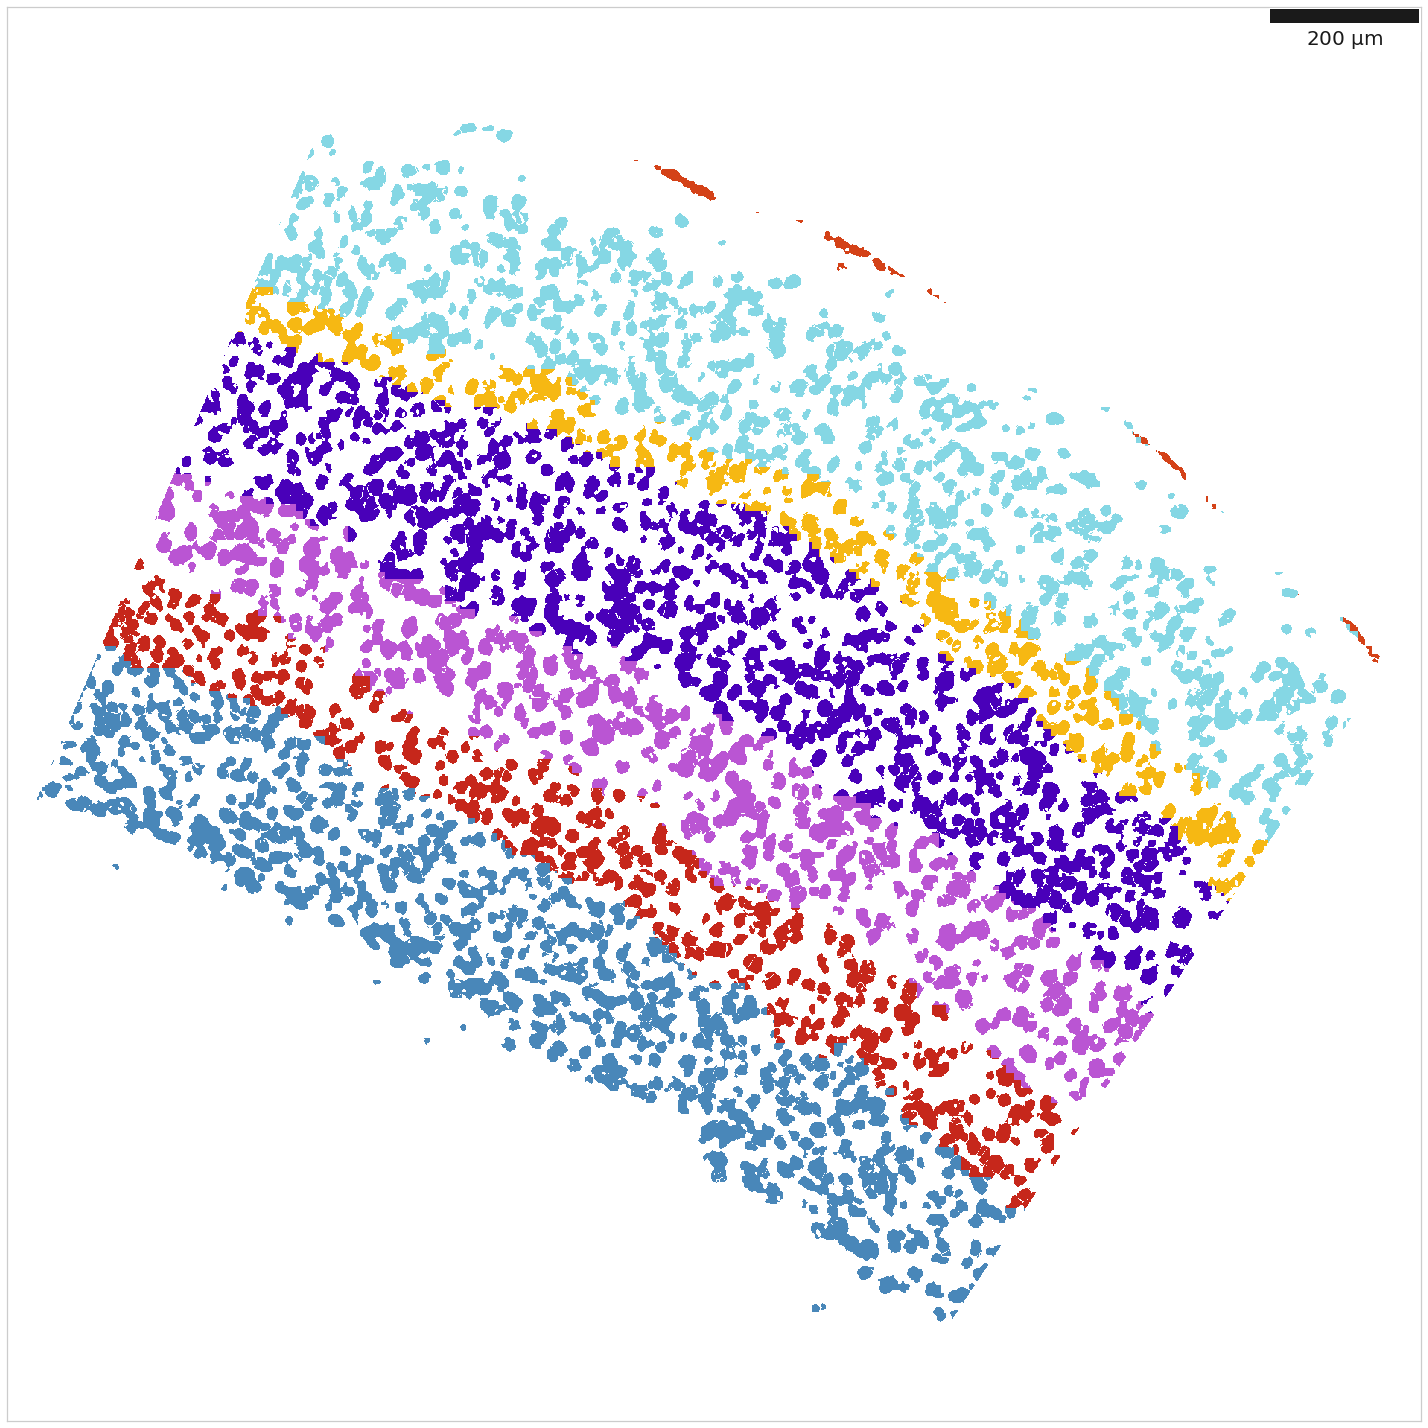

In [59]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=[20, 20])
cmap = ListedColormap([domain_colors[lbl] for lbl in domain_labels])
ds.plot_domains(rotate=1, cmap=cmap)
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.xlim([2050, 150])
plt.ylim([2050, 150])
plt.tight_layout()

In [60]:
analysis.calc_cell_type_compositions()

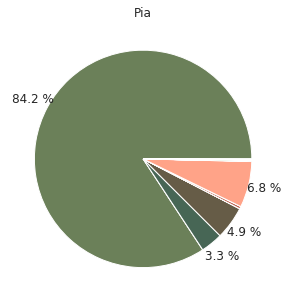

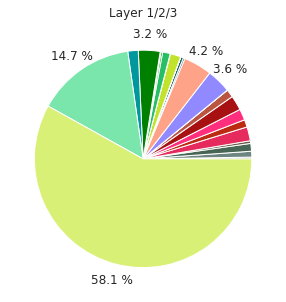

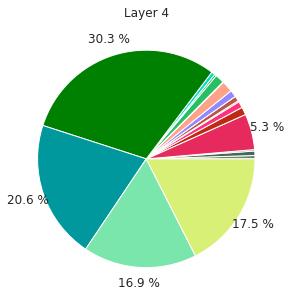

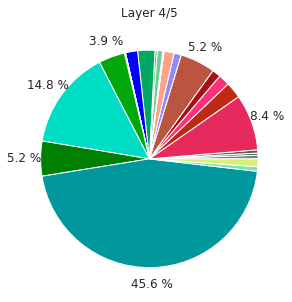

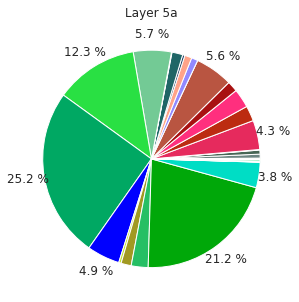

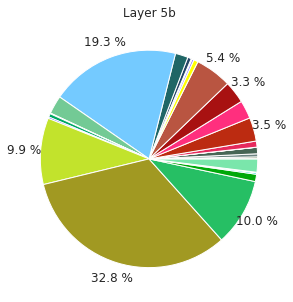

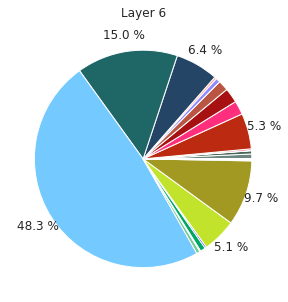

In [61]:
for domain_idx in [1, 0, 2, 3, 4, 5, 6]:
    plt.figure(figsize=[5, 5])
    ds.plot_celltype_composition(domain_idx,
                                 cell_type_colors=denovo_celltype_colors,
                                 cell_type_orders=heatmap_clusters_index[::-1],
                                 label_cutoff=0.03)
    plt.title(domain_labels[domain_idx])

Text(0.5, 1.0, 'All')

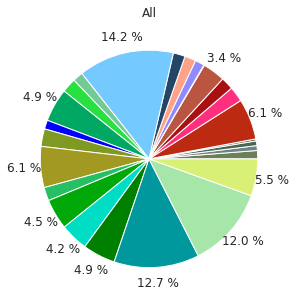

In [66]:
plt.figure(figsize=[5, 5])
ds.plot_celltype_composition(domain_index=7,
                             cell_type_colors=denovo_celltype_colors,
                             cell_type_orders=heatmap_clusters_index[::-1],
                             label_cutoff=0.03)
plt.title('All')